# Il problema

Un azienda automobilistica ha intenzione di espandersi in un nuovo mercato utilizzando la sua gamma di prodotti già esistenti (P1, P2, P3, P4, e P5). Dopo alcune ricerche hanno scoperto che il comportamento sul nuovo mercato di obiettivo è simile a quello in cui operano attualmente.

Nell'attuale mercato il team di vendite ha classificato i possibili acquirenti in 4 diverse categorie (A, B, C, D). Con questa segmentazione possono proporre servizi e pubblicità mirate per i diversi tipi di clienti. Questa stategia ha funzionato particolarmente bene finora e quindi l'azienda punta ad utilizzarla anche sul nuovo mercato dove ha identificato 2627 possibili nuovi clienti.

L'obiettivo è quello di prevedere correttamente il gruppo di appartenzenza dei nuovi clienti.

## I dati

| Variable | Definition |
| :-: | :-: |
| ID | Identificativo univoco|
| Gender | Sesso del cliente|
| Ever_Married | Stato civile del cliente |
| Age | Età del cliente |
| Graduated | Il cliente è laureato? |
| Profession | Lavoro del cliente |
| Work_Experiecen | Esperienza lavorativa in anni |
| Spending_Score | Punteggio di spesa del cliente |
| Family Size | Numero di componenti del nucleo familiare del cliente (cliente incluso)|
| Var_1 | Categoria anonima per il cliente |
| Segmentation | (target) Segmento di appartenenza del cliente|


In [81]:
#Data wrangling
import numpy as np
import pandas as pd
from collections import Counter

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno
from matplotlib.ticker import EngFormatter
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

#Machine Learning 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

#Model evaluation 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

plt.rcParams["figure.figsize"] = 10,6
plt.style.use('ggplot')

## Import 

In [2]:
train_data = pd.read_csv('Customer_Train.csv')
test_data = pd.read_csv('Customer_Test.csv')
data = pd.concat([train_data, test_data])
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [3]:
print('Train set shape:',train_data.shape)
print('Test set shape:',test_data.shape)

Train set shape: (8068, 11)
Test set shape: (2627, 11)


In realtà i due set non sono divisi in modo corretto perché la variabile target è contenuta anche nel test set, per questo uniamo i due dataframe e li consideriamo insieme. Successivamente, prima di applicare il modello di machine learning divideremo i dati in train e test.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10695 entries, 0 to 2626
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10695 non-null  int64  
 1   Gender           10695 non-null  object 
 2   Ever_Married     10505 non-null  object 
 3   Age              10695 non-null  int64  
 4   Graduated        10593 non-null  object 
 5   Profession       10533 non-null  object 
 6   Work_Experience  9597 non-null   float64
 7   Spending_Score   10695 non-null  object 
 8   Family_Size      10247 non-null  float64
 9   Var_1            10587 non-null  object 
 10  Segmentation     10695 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 1002.7+ KB


Si noti che le colonne che contengono varaibili qualitative ordinali o binarie, sono resgristate come "object". Dovremo codificarle correttamente prima di applicare un algoritmo di Machine Learning. È anche possibile vedere che ci sono dei dati mancanti, studiamoli più nel dettaglio.

In [5]:
data.isnull().sum()

ID                    0
Gender                0
Ever_Married        190
Age                   0
Graduated           102
Profession          162
Work_Experience    1098
Spending_Score        0
Family_Size         448
Var_1               108
Segmentation          0
dtype: int64

Abbiamo diverse colonne con valori mancanti che dobbiamo gestire, tuttavia non è detto che sia possibile usare lo stesso modello per tutte. Ad esempio i valori mancanti della colonna _Work_Experience_ potrebbero indicare persone che non sono mai state impiegate, e quindi sarebbe utile sostituire questi valori mancanti con 0; la stessa cosa vale per la colonna _Profession_, i valori mancanti potrebbero indicare persone che sono attualmente disoccupate.

Visualizziamo la distribuzione dei dati mancanti:

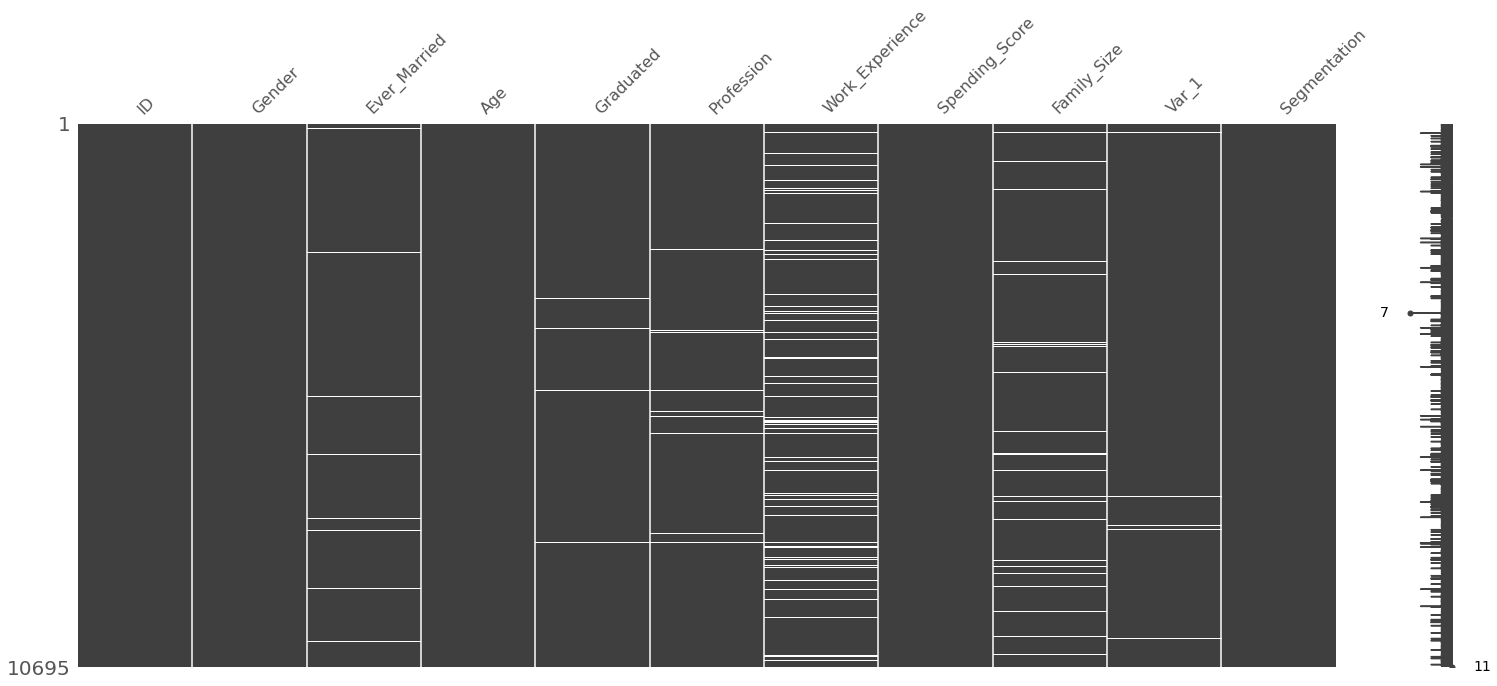

In [6]:
missingno.matrix(data)
plt.show()

Le colonne più problematiche a livello di dati mancanti sono _Work_experience_ e _Familiy_Size_. A volte utilizzando una rappresentazione grafica è più facile avere un'idea di come sono composti i dati con cui stiamo lavorando.

In [7]:
data.duplicated().sum()

38

Sono presenti anche dei valori duplicati.

In [8]:
data.describe()

,ID,Age,Work_Experience,Family_Size
count,10695.000000,10695.000000,9597.000000,10247.000000
mean,463468.088640,43.511828,2.619777,2.844052
std,2600.966411,16.774158,3.390790,1.536427
min,458982.000000,18.000000,0.000000,1.000000
25%,461220.500000,30.000000,0.000000,2.000000
50%,463451.000000,41.000000,1.000000,3.000000
75%,465733.500000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [9]:
#Visualizzo le variabili categoriche

categorical_col = data.select_dtypes('object')
for i in categorical_col:
    print(data[i].value_counts(), end="\n\n")

Male      5841
Female    4854
Name: Gender, dtype: int64

Yes    6163
No     4342
Name: Ever_Married, dtype: int64

Yes    6570
No     4023
Name: Graduated, dtype: int64

Artist           3318
Healthcare       1750
Entertainment    1250
Engineer          935
Doctor            930
Lawyer            844
Executive         775
Marketing         403
Homemaker         328
Name: Profession, dtype: int64

Low        6494
Average    2599
High       1602
Name: Spending_Score, dtype: int64

Cat_6    6910
Cat_4    1475
Cat_3    1089
Cat_2     563
Cat_7     269
Cat_1     167
Cat_5     114
Name: Var_1, dtype: int64

D    3027
A    2818
C    2442
B    2408
Name: Segmentation, dtype: int64



# Pulizia dei dati 

Come prima cosa rimuoviamo i valori duplicati 

In [10]:
data.drop_duplicates(inplace=True)

Adesso dobbiamo decidere come gestire i dati che presentano dei valori mancanti. Possiamo eliminare le righe o le colonne che contengono i valori mancanti, oppure decidere di sostituire i dati mancanti con altri valori significativi in base alla variabile che stiamo considerando.

Per quanto riguarda le variabili numeriche Work_Experience e Family_Size, sostituiamo i valori mancanti con la mediana, in modo da non subire l'effetto di outliers.

Per quanto riguarda le variabili categoriche, consideriamo i valori mancanti di Ever_Married come 'No', i valori mancanti di Graduated come 'No' e eliminiamo i valori mancanti di Profession e Var_1 perché non abbiamo un modo efficiente per sostituirli.

Calcoliamo la mediana di Work_Experience e Family_Size

In [11]:
W_median = data['Work_Experience'].median()
F_median = data['Family_Size'].median()

print('Work_Experience median:', W_median)
print('Family_Size median:', F_median)

Work_Experience median: 1.0
Family_Size median: 2.0


In [12]:
#Sostituisco i valori mancanti per tutte le variabili
data['Work_Experience'] = data['Work_Experience'].fillna(W_median)
data['Family_Size'] = data['Family_Size'].fillna(F_median)
data['Ever_Married'].fillna('No',inplace=True)
data['Graduated'].fillna('No',inplace=True)
data.dropna(subset=['Profession'],inplace=True)
data.dropna(subset=['Var_1'],inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10390 entries, 0 to 2626
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10390 non-null  int64  
 1   Gender           10390 non-null  object 
 2   Ever_Married     10390 non-null  object 
 3   Age              10390 non-null  int64  
 4   Graduated        10390 non-null  object 
 5   Profession       10390 non-null  object 
 6   Work_Experience  10390 non-null  float64
 7   Spending_Score   10390 non-null  object 
 8   Family_Size      10390 non-null  float64
 9   Var_1            10390 non-null  object 
 10  Segmentation     10390 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 974.1+ KB


Infine rimuoviamo la colonna ID perché non verrà usata nell'analisi

In [13]:
data = data.drop('ID', axis=1)

## Exploratory Data Analysis

### variabili categoriche

Ricordiamo che la nostra variabile target è _Segmentation_ quindi visualizziamo come si comporta questa variabile rispetto alle features categoriche.

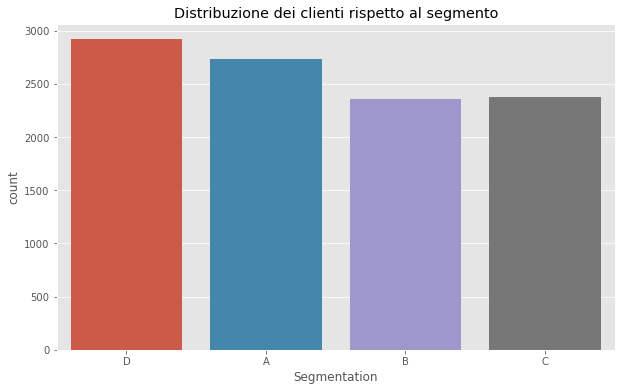

In [14]:
sns.countplot(x=data.Segmentation)
plt.title('Distribuzione dei clienti rispetto al segmento');

Il segmento D è il più rappresentativo.

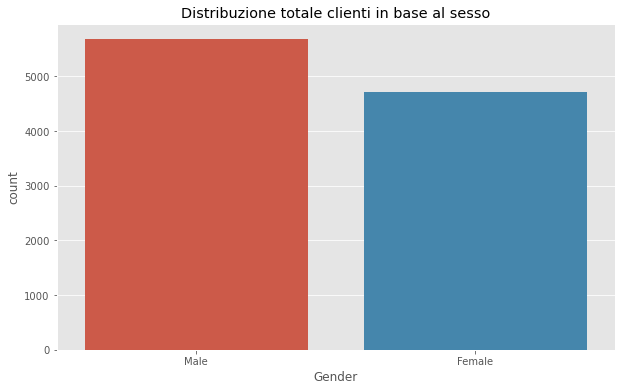

In [15]:
sns.countplot(x=data.Gender)
plt.title('Distribuzione totale clienti in base al sesso');

La maggioranza della clientela è composta da individui di sesso maschile.

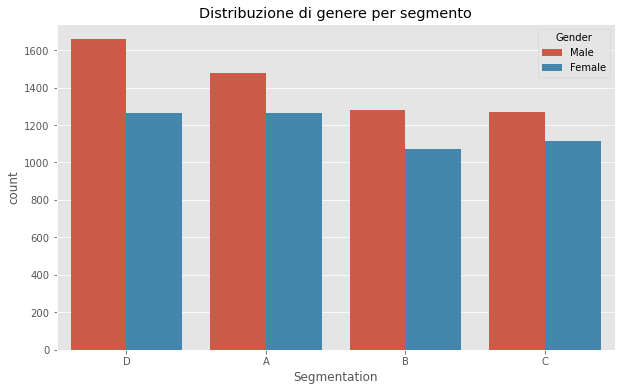

In [16]:
sns.countplot(data=data, x='Segmentation', hue='Gender')
plt.title('Distribuzione di genere per segmento');

In ogni segmento gli uomini sono la maggioranza. La differenza minore si registra nel segmento C.

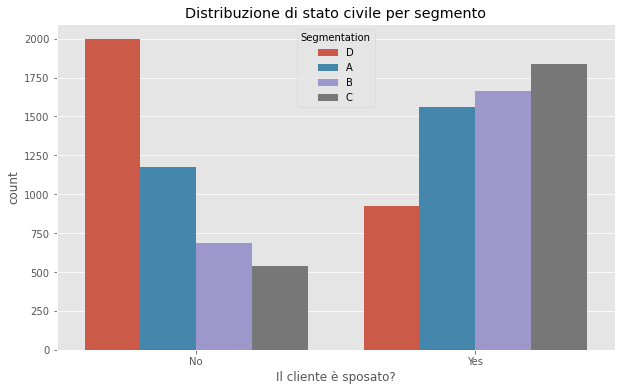

In [17]:
sns.countplot(data=data, x='Ever_Married', hue='Segmentation')
plt.title('Distribuzione di stato civile per segmento')
plt.xlabel('Il cliente è sposato?');

Il segmento D è quello composto in maggioranta da clienti non sposati. L'opposto avviene nel segmento C, dove la maggiorparte della clientela è sposata. Anche er quanto riguarda gli altri segmenti i clienti sposati sono la maggioranza. Probabilmente il segmento D fa riferimento ad auto sportive, per questo ci sono più clienti non sposati.

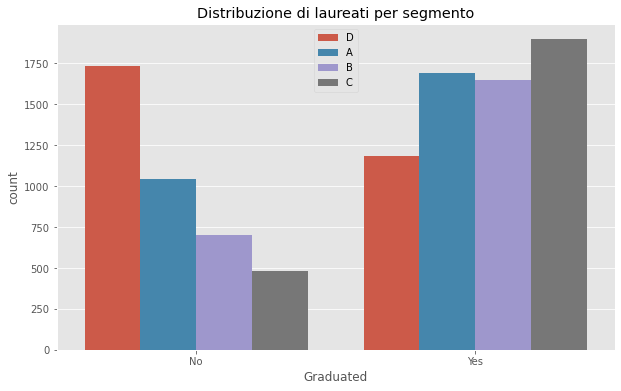

In [18]:
sns.countplot(data=data, x='Graduated', hue='Segmentation')
plt.legend(loc='upper center')
plt.title('Distribuzione di laureati per segmento');

Osservando gli ultimi due grafici, possiamo notare che il segmento D è quello che contiene la maggioranza di clienti non laureati e non sposati. In precedenza avevamo ipotizzato che il segmento D potesse far riferimento alle automobili sportive. Tuttavia notiamo che la maggiorparte dei cienti nel segmento D non è laureata, e di solito ciò corrisponde ad un livello di reddito più basso che non dovrebbe essere compatibile con il segmento delle auto sportive, ma potrebbe corrispondere al segmento delle auto più economiche oppure usate. Visualizziamo quali sono le principali attività lavorative dei nostri clienti.

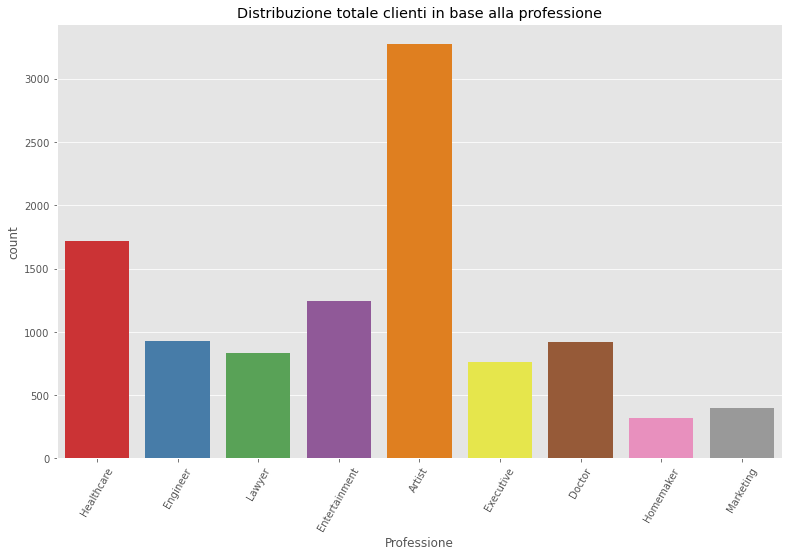

In [19]:
plt.figure(figsize=(13,8))
sns.countplot(x=data.Profession, palette = 'Set1')
plt.title('Distribuzione totale clienti in base alla professione')
plt.xlabel('Professione')
plt.xticks(rotation=60);

La maggior parte dei clienti sono artisti, mentre la seconda professione più rappresentata è l'assistenza sanitaria. Adesso normalizziamo il numero di clienti e vediamo come si distribuiscono, in percentuale, all'interno dei vari segmenti.

In [20]:
prof=data.groupby('Segmentation')['Profession'].value_counts(normalize=True).round(decimals=2).unstack()*100


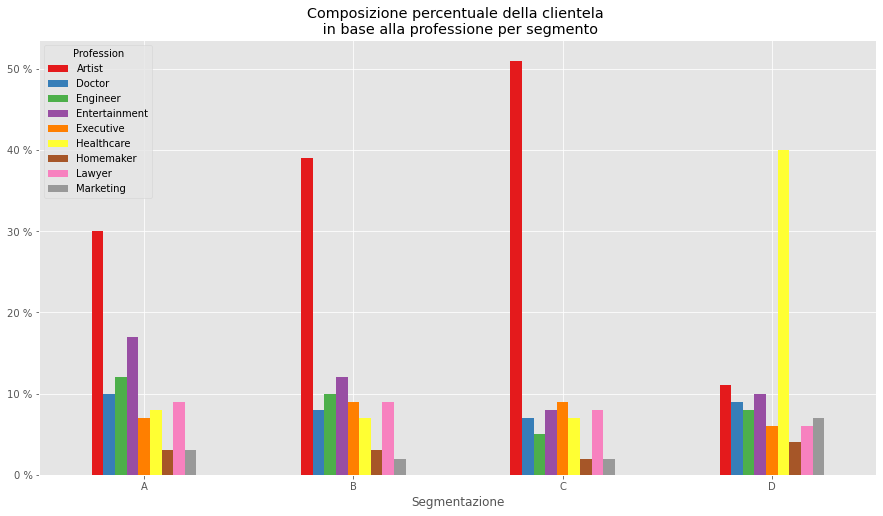

In [21]:
fig,ax = plt.subplots(1,1, figsize=(15,8))
col=sns.color_palette('Set1')
prof.plot(kind='bar',ax=ax, color=col)
ax.yaxis.set_major_formatter(EngFormatter(unit=u"%"))
ax.tick_params(axis='x', labelrotation=0)
ax.set_xlabel('Segmentazione')
ax.set_title('Composizione percentuale della clientela \n in base alla professione per segmento');

Il grafico mostra la composizione in percentuale della clientela per ogni segmento, suddivisa in base alla professione. Nei primi 3 segmenti la maggioranza dei clienti è composta da artisti, che sono anche la professione più rappresentata in termini assoluti. In particolare, per quanto riguarda il segmento C, gli artisti rappresentano più del 50% della clientela; probabilmente i veicoli di questo segmento hanno qualcosa utile alla professione degli artisti o una caratteristica estetica che attira di più le persone che lavorano nel mondo dell'arte. Per quanto riguarda il segmento D invece abbiamo un comportamento diverso . Circa il 40% dei clienti di questo segmento svolgono professioni relative all'assistenza sanitaria. Dai grafici precedenti abbiamo visto anche che il segmento D è quello più scelto dai clienti non sposati e non laureati. Per quanto riguarda il titolo di studio ha senso, perché non è necessaria una laurea per essere impiegati nell'assistenza sanitaria. Per quanto riguarda il reddito invece non possiamo trarre ulteriori conclusioni perché, come possiamo vedere dal grafico, anche professioni ad alto reddito (come dirigenti e avvocati) sono abbastanza rappresentate anche nel segmento D. 

Vediamo come è distribuito il punteggio di spesa del cliente rispetto ai segmenti

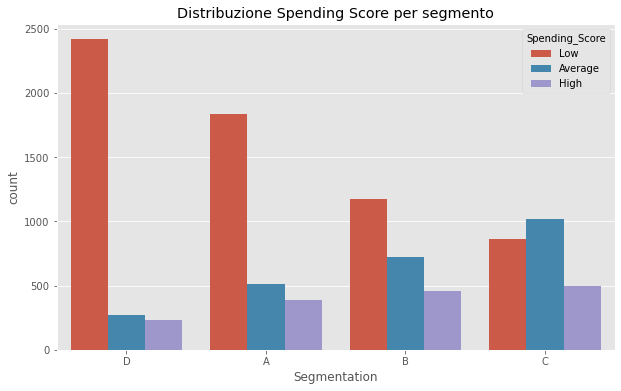

In [22]:
sns.countplot(data=data, x='Segmentation', hue='Spending_Score')
plt.title('Distribuzione Spending Score per segmento');

Nel segmento D ritroviamo la maggior parte dei clienti con un punteggio di spesa basso. Questa categoria costituisce comuneque la classe dominante in tutti i segmeti tranne in quello C, dove la più rappresentativa è quella con punteggio di spesa medio, ed è anche la classe con più clienti con punteggio di spesa alto. Ricordiamo che lo spending score è un punteggio assegnato in base alle spese effettuate dai clienti e dal loro comportamento in generale. Senza sapere come questo score viene calcolato non possiamo trarre ulteriori conclusioni dal grafico.

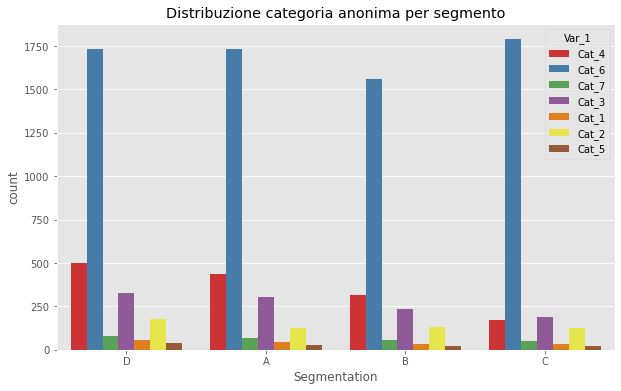

In [23]:
sns.countplot(data=data, x='Segmentation', hue='Var_1', 
              palette = 'Set1')
plt.title('Distribuzione categoria anonima per segmento');

La categoria 6 è la più rappresentativa in ogni segmento 

### variabili numeriche

Le variabili numeriche sono Age, Work_Experience e Family_Size. Come prima cosa definiamo una funzione per identificare i valori outliers nelle variabili numeriche e rimuoverli.

In [24]:
def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(key for key, value in outlier_indices.items() if value > n )
    return multiple_outliers
outliers_to_drop = detect_outliers(data, 2, ['Age', 'Work_Experience', 'Family_Size'])
print('dobbiamo eliminare {} indici:'.format(len(outliers_to_drop)), outliers_to_drop)

dobbiamo eliminare 0 indici: []


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10390 entries, 0 to 2626
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           10390 non-null  object 
 1   Ever_Married     10390 non-null  object 
 2   Age              10390 non-null  int64  
 3   Graduated        10390 non-null  object 
 4   Profession       10390 non-null  object 
 5   Work_Experience  10390 non-null  float64
 6   Spending_Score   10390 non-null  object 
 7   Family_Size      10390 non-null  float64
 8   Var_1            10390 non-null  object 
 9   Segmentation     10390 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 1.1+ MB


In Questo dataset non abbiamo valori outliers da eliminare. Visualizziamo la correlazione delle variabili numeriche con la correlation matrix

Text(0.5, 1.0, 'Correlazione fra le variabili numeriche')

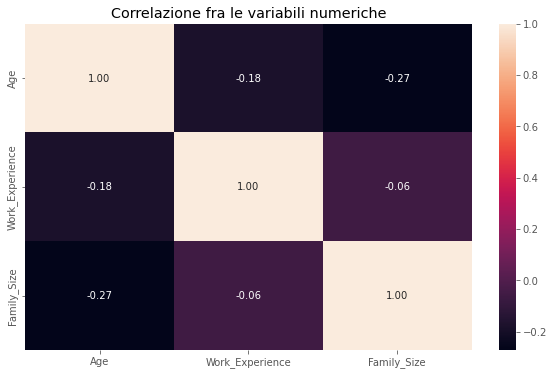

In [26]:
sns.heatmap(data[['Segmentation','Age','Work_Experience','Family_Size']].corr(), annot=True, fmt='.2f')
plt.title('Correlazione fra le variabili numeriche')

Possiamo vedere che le variabili Età e esperienza lavorativa sono negativamente correlate, che è una cosa normale.

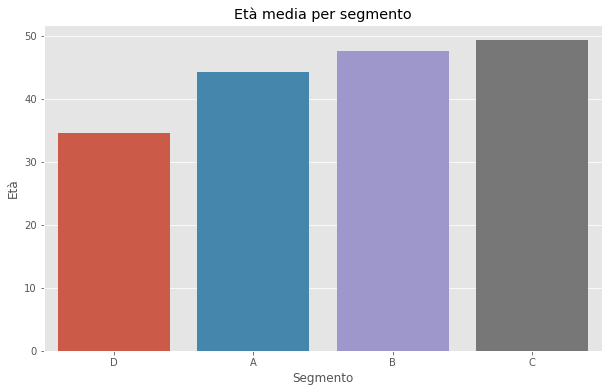

In [27]:
sns.barplot(y='Age', x='Segmentation', data=data, ci=None)
plt.title('Età media per segmento')
plt.xlabel('Segmento')
plt.ylabel('Età');

Il segmento D è quello con l'età media minore, mentre il segmento C registra l'età media più elevata.

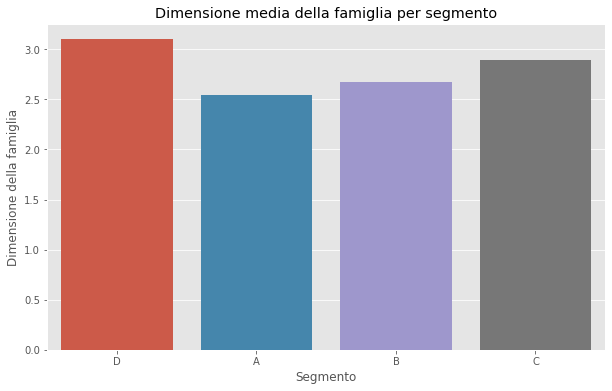

In [28]:
sns.barplot(y='Family_Size', x='Segmentation',data=data, ci=None)
plt.title('Dimensione media della famiglia per segmento')
plt.xlabel('Segmento')
plt.ylabel('Dimensione della famiglia');

Il segmento D in media ha i clienti con le famiglie più numerose.

In [29]:
Work_S =  data[['Segmentation','Work_Experience']].groupby('Segmentation', as_index=False).mean().sort_values(by= 'Segmentation', ascending=False)
print(Work_S)

  Segmentation  Work_Experience
3            D         2.694521
2            C         2.143277
1            B         2.263918
0            A         2.668615


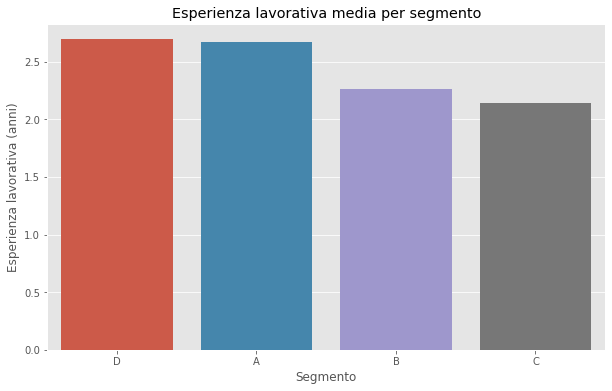

In [30]:
sns.barplot(y='Work_Experience', x='Segmentation', data=data, ci=None)
plt.title('Esperienza lavorativa media per segmento')
plt.xlabel('Segmento')
plt.ylabel('Esperienza lavorativa (anni)');

La classe D e la classe A sono molto simili in termini di esperienza lavorativa media, ma ricordiamo che la classe D è il segmento con l'età media più bassa.

# Preprocessing


## Encoding

Prima di addestrare un modello di machine learning, dobbiamo assicurarci che tutte le variabili categoriche siano espresse in termini numerici.

In [31]:
data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,A
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6,A


In [32]:
data.dtypes

Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation        object
dtype: object

In [33]:
#selezione solo le colonne non numeriche
non_numeric = data.select_dtypes('object')
non_numeric.columns

Index(['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score',
       'Var_1', 'Segmentation'],
      dtype='object')

In [34]:
#Valori unici per ogni colonna non numerica
for column in non_numeric:
    print(f"{column}: {data[column].unique()}")

Gender: ['Male' 'Female']
Ever_Married: ['No' 'Yes']
Graduated: ['No' 'Yes']
Profession: ['Healthcare' 'Engineer' 'Lawyer' 'Entertainment' 'Artist' 'Executive'
 'Doctor' 'Homemaker' 'Marketing']
Spending_Score: ['Low' 'Average' 'High']
Var_1: ['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1' 'Cat_2' 'Cat_5']
Segmentation: ['D' 'A' 'B' 'C']


In [35]:
#Codifica one hot
data = pd.get_dummies(data, columns=['Profession','Spending_Score', 'Var_1'])
data

,Gender,Ever_Married,Age,Graduated,Work_Experience,Family_Size,Segmentation,Profession_Artist,Profession_Doctor,Profession_Engineer,...,Spending_Score_Average,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,Male,No,22,No,1.0,4.0,D,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,Female,Yes,38,Yes,1.0,3.0,A,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,Female,Yes,67,Yes,1.0,1.0,B,0,0,1,...,0,0,1,0,0,0,0,0,1,0
3,Male,Yes,67,Yes,0.0,2.0,B,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,Female,Yes,40,Yes,1.0,6.0,A,0,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2622,Male,No,29,No,9.0,4.0,B,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2623,Female,No,35,Yes,1.0,1.0,A,0,1,0,...,0,0,1,0,0,0,0,0,1,0
2624,Female,No,53,Yes,1.0,2.0,C,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2625,Male,Yes,47,Yes,1.0,5.0,C,0,0,0,...,0,1,0,0,0,0,1,0,0,0


A questo punto ci restano soltanto le variabili binarie e la variabile target (che non posso convertire con la codifica one hot) che possiamo convertire utilizzando LabelEncoder. Come prima cosa riselezioniamo le colonne non numeriche che sono rimaste dopo la prima trasformazione.

In [36]:
non_numeric = data.select_dtypes('object')
non_numeric.columns

Index(['Gender', 'Ever_Married', 'Graduated', 'Segmentation'], dtype='object')

In [37]:
encoder=LabelEncoder()

#Converto le colonne binarie
for column in non_numeric:
    data[column] = encoder.fit_transform(data[column])

In [38]:
data.dtypes

Gender                        int32
Ever_Married                  int32
Age                           int64
Graduated                     int32
Work_Experience             float64
Family_Size                 float64
Segmentation                  int32
Profession_Artist             uint8
Profession_Doctor             uint8
Profession_Engineer           uint8
Profession_Entertainment      uint8
Profession_Executive          uint8
Profession_Healthcare         uint8
Profession_Homemaker          uint8
Profession_Lawyer             uint8
Profession_Marketing          uint8
Spending_Score_Average        uint8
Spending_Score_High           uint8
Spending_Score_Low            uint8
Var_1_Cat_1                   uint8
Var_1_Cat_2                   uint8
Var_1_Cat_3                   uint8
Var_1_Cat_4                   uint8
Var_1_Cat_5                   uint8
Var_1_Cat_6                   uint8
Var_1_Cat_7                   uint8
dtype: object

Adesso le variabili sono tutte numeriche e possono essere usate in un modello di machine learning

## Split

La nostra variabile target è il segmento di appartenenza dei clienti. 

In [39]:
y = data['Segmentation'].copy()

In [40]:
X = data.drop('Segmentation', axis=1)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [42]:
print('X_train shape : {}'.format(X_train.shape))
print('y_train shape : {}'.format(y_train.shape))
print('X_test shape : {}'.format(X_test.shape))
print('y_test shape : {}'.format(y_test.shape))

X_train shape : (7272, 25)
y_train shape : (7272,)
X_test shape : (3118, 25)
y_test shape : (3118,)


## Scaling

Utilizzo **Standard Scaler** per scalare i dati 

In [43]:
scaler = StandardScaler()
#fit_transform per il train test
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
#transform per il test set
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [44]:
X_train

,Gender,Ever_Married,Age,Graduated,Work_Experience,Family_Size,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,...,Spending_Score_Average,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,0.917322,0.864186,-0.750059,0.784399,1.380336,-0.524825,-0.681438,-0.312241,-0.312241,-0.364778,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
1,-1.090130,-1.157158,-1.350768,-1.274861,-0.758618,-0.524825,-0.681438,-0.312241,-0.312241,-0.364778,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,2.502945,-0.10345,-1.387085,-0.149991
2,0.917322,0.864186,0.090932,-1.274861,-0.453053,0.139265,1.467485,-0.312241,-0.312241,-0.364778,...,1.773683,-0.416499,-1.253204,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
3,0.917322,-1.157158,-0.689989,-1.274861,-0.758618,-1.188915,-0.681438,-0.312241,-0.312241,2.741391,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
4,-1.090130,-1.157158,-0.209422,0.784399,1.074771,-0.524825,-0.681438,-0.312241,-0.312241,-0.364778,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7267,0.917322,0.864186,0.391287,-1.274861,-0.453053,0.139265,-0.681438,-0.312241,-0.312241,2.741391,...,1.773683,-0.416499,-1.253204,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
7268,-1.090130,-1.157158,-0.750059,0.784399,1.991466,-1.188915,-0.681438,-0.312241,-0.312241,-0.364778,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
7269,0.917322,-1.157158,-0.930272,-1.274861,-0.453053,-0.524825,-0.681438,-0.312241,-0.312241,2.741391,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
7270,0.917322,0.864186,-0.149351,-1.274861,1.074771,0.139265,-0.681438,-0.312241,-0.312241,-0.364778,...,-0.563799,2.400969,-1.253204,-0.131169,-0.241262,-0.333028,2.502945,-0.10345,-1.387085,-0.149991


In [45]:
X_test

,Gender,Ever_Married,Age,Graduated,Work_Experience,Family_Size,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,...,Spending_Score_Average,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,-1.090130,-1.157158,-0.029209,0.784399,-0.453053,-0.524825,1.467485,-0.312241,-0.312241,-0.364778,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
1,-1.090130,-1.157158,-0.509776,0.784399,1.991466,-1.188915,-0.681438,-0.312241,-0.312241,-0.364778,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
2,-1.090130,0.864186,1.292349,0.784399,-0.758618,-0.524825,1.467485,-0.312241,-0.312241,-0.364778,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
3,0.917322,-1.157158,-0.870201,-1.274861,-0.453053,0.803356,-0.681438,3.202650,-0.312241,-0.364778,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
4,0.917322,-1.157158,-1.470909,-1.274861,3.213725,0.139265,-0.681438,-0.312241,-0.312241,-0.364778,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,-1.387085,6.667083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3113,0.917322,-1.157158,-1.110484,0.784399,1.685901,-1.188915,-0.681438,3.202650,-0.312241,-0.364778,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
3114,0.917322,0.864186,-0.629918,-1.274861,-0.758618,-0.524825,-0.681438,-0.312241,3.202650,-0.364778,...,1.773683,-0.416499,-1.253204,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
3115,0.917322,-1.157158,-1.290697,-1.274861,-0.453053,0.139265,-0.681438,-0.312241,-0.312241,-0.364778,...,-0.563799,-0.416499,0.797955,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991
3116,0.917322,0.864186,0.811782,0.784399,-0.453053,1.467446,-0.681438,-0.312241,-0.312241,-0.364778,...,1.773683,-0.416499,-1.253204,-0.131169,-0.241262,-0.333028,-0.399529,-0.10345,0.720936,-0.149991


A questo punto possiamo addestrare i nostri modelli di machine learning.

# Machine Learning

## Addestramento Modelli

### Logistic Regression

In [46]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

46.69

### Support Vector Machines

In [47]:
svc = SVC()
svc.fit(X_train, y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train)*100, 2)
acc_svc

51.24

### K-nearest neighbours (KNN)

In [48]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
acc_knn

58.68

### Gaussian naive bayes

In [49]:
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)
acc_gaussian

43.78

### Perceptron

In [50]:
perceptron = Perceptron()
perceptron.fit(X_train, y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, y_train) * 100, 2)
acc_perceptron

32.04

### Linear SVC

In [51]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)
acc_linear_svc

46.18

### Stochastic gradient descent

In [52]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)
acc_sgd

40.58

### Decision Tree

In [53]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree

93.45

### Random Forest


In [54]:
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

93.45

### Cat Boost

In [55]:
catboost = CatBoostClassifier()
catboost.fit(X_train, y_train)
Y_pred = catboost.predict(X_test)
acc_catboost = round(catboost.score(X_train, y_train) * 100, 2)

Learning rate set to 0.087552
0:	learn: 1.3545109	total: 166ms	remaining: 2m 45s
1:	learn: 1.3307037	total: 175ms	remaining: 1m 27s
2:	learn: 1.3090748	total: 181ms	remaining: 1m
3:	learn: 1.2943176	total: 186ms	remaining: 46.4s
4:	learn: 1.2800594	total: 193ms	remaining: 38.4s
5:	learn: 1.2675033	total: 198ms	remaining: 32.9s
6:	learn: 1.2556384	total: 204ms	remaining: 29s
7:	learn: 1.2449880	total: 210ms	remaining: 26s
8:	learn: 1.2363847	total: 215ms	remaining: 23.7s
9:	learn: 1.2293660	total: 221ms	remaining: 21.9s
10:	learn: 1.2223872	total: 227ms	remaining: 20.4s
11:	learn: 1.2164482	total: 233ms	remaining: 19.2s
12:	learn: 1.2114840	total: 240ms	remaining: 18.2s
13:	learn: 1.2063734	total: 246ms	remaining: 17.3s
14:	learn: 1.2026582	total: 252ms	remaining: 16.5s
15:	learn: 1.1983823	total: 258ms	remaining: 15.9s
16:	learn: 1.1950525	total: 264ms	remaining: 15.2s
17:	learn: 1.1917383	total: 270ms	remaining: 14.7s
18:	learn: 1.1888272	total: 277ms	remaining: 14.3s
19:	learn: 1.186

165:	learn: 1.0720375	total: 1.24s	remaining: 6.25s
166:	learn: 1.0714520	total: 1.25s	remaining: 6.24s
167:	learn: 1.0711431	total: 1.26s	remaining: 6.22s
168:	learn: 1.0705652	total: 1.26s	remaining: 6.22s
169:	learn: 1.0699963	total: 1.27s	remaining: 6.21s
170:	learn: 1.0693380	total: 1.28s	remaining: 6.19s
171:	learn: 1.0687676	total: 1.28s	remaining: 6.18s
172:	learn: 1.0682489	total: 1.29s	remaining: 6.17s
173:	learn: 1.0678311	total: 1.3s	remaining: 6.16s
174:	learn: 1.0673937	total: 1.3s	remaining: 6.14s
175:	learn: 1.0668151	total: 1.31s	remaining: 6.13s
176:	learn: 1.0662491	total: 1.32s	remaining: 6.12s
177:	learn: 1.0657513	total: 1.32s	remaining: 6.11s
178:	learn: 1.0651416	total: 1.33s	remaining: 6.1s
179:	learn: 1.0645961	total: 1.33s	remaining: 6.08s
180:	learn: 1.0641366	total: 1.34s	remaining: 6.07s
181:	learn: 1.0637697	total: 1.35s	remaining: 6.06s
182:	learn: 1.0634153	total: 1.35s	remaining: 6.05s
183:	learn: 1.0631639	total: 1.36s	remaining: 6.04s
184:	learn: 1.0

341:	learn: 0.9957976	total: 2.48s	remaining: 4.77s
342:	learn: 0.9953913	total: 2.49s	remaining: 4.77s
343:	learn: 0.9949340	total: 2.53s	remaining: 4.83s
344:	learn: 0.9945999	total: 2.54s	remaining: 4.83s
345:	learn: 0.9944090	total: 2.55s	remaining: 4.82s
346:	learn: 0.9939894	total: 2.57s	remaining: 4.83s
347:	learn: 0.9933361	total: 2.57s	remaining: 4.82s
348:	learn: 0.9930046	total: 2.58s	remaining: 4.82s
349:	learn: 0.9926653	total: 2.6s	remaining: 4.83s
350:	learn: 0.9921511	total: 2.61s	remaining: 4.82s
351:	learn: 0.9919027	total: 2.62s	remaining: 4.82s
352:	learn: 0.9915529	total: 2.63s	remaining: 4.83s
353:	learn: 0.9913492	total: 2.65s	remaining: 4.83s
354:	learn: 0.9909562	total: 2.65s	remaining: 4.82s
355:	learn: 0.9907152	total: 2.66s	remaining: 4.82s
356:	learn: 0.9904323	total: 2.67s	remaining: 4.81s
357:	learn: 0.9901874	total: 2.68s	remaining: 4.81s
358:	learn: 0.9899199	total: 2.69s	remaining: 4.8s
359:	learn: 0.9896585	total: 2.7s	remaining: 4.8s
360:	learn: 0.98

500:	learn: 0.9420035	total: 3.75s	remaining: 3.74s
501:	learn: 0.9418306	total: 3.76s	remaining: 3.73s
502:	learn: 0.9416913	total: 3.77s	remaining: 3.72s
503:	learn: 0.9413605	total: 3.77s	remaining: 3.71s
504:	learn: 0.9409814	total: 3.78s	remaining: 3.71s
505:	learn: 0.9407267	total: 3.79s	remaining: 3.7s
506:	learn: 0.9405189	total: 3.8s	remaining: 3.69s
507:	learn: 0.9401685	total: 3.81s	remaining: 3.69s
508:	learn: 0.9399227	total: 3.81s	remaining: 3.68s
509:	learn: 0.9397158	total: 3.82s	remaining: 3.67s
510:	learn: 0.9393626	total: 3.83s	remaining: 3.66s
511:	learn: 0.9388314	total: 3.83s	remaining: 3.65s
512:	learn: 0.9385936	total: 3.84s	remaining: 3.64s
513:	learn: 0.9382610	total: 3.85s	remaining: 3.63s
514:	learn: 0.9380449	total: 3.85s	remaining: 3.63s
515:	learn: 0.9378009	total: 3.86s	remaining: 3.62s
516:	learn: 0.9376434	total: 3.87s	remaining: 3.61s
517:	learn: 0.9374308	total: 3.87s	remaining: 3.6s
518:	learn: 0.9370939	total: 3.88s	remaining: 3.6s
519:	learn: 0.93

680:	learn: 0.8910616	total: 5.01s	remaining: 2.35s
681:	learn: 0.8908771	total: 5.01s	remaining: 2.34s
682:	learn: 0.8904833	total: 5.02s	remaining: 2.33s
683:	learn: 0.8900245	total: 5.03s	remaining: 2.32s
684:	learn: 0.8898471	total: 5.03s	remaining: 2.31s
685:	learn: 0.8897184	total: 5.04s	remaining: 2.31s
686:	learn: 0.8894234	total: 5.05s	remaining: 2.3s
687:	learn: 0.8892175	total: 5.05s	remaining: 2.29s
688:	learn: 0.8889803	total: 5.06s	remaining: 2.28s
689:	learn: 0.8887513	total: 5.07s	remaining: 2.28s
690:	learn: 0.8884179	total: 5.07s	remaining: 2.27s
691:	learn: 0.8882507	total: 5.08s	remaining: 2.26s
692:	learn: 0.8880770	total: 5.09s	remaining: 2.25s
693:	learn: 0.8877674	total: 5.09s	remaining: 2.25s
694:	learn: 0.8873858	total: 5.1s	remaining: 2.24s
695:	learn: 0.8871860	total: 5.11s	remaining: 2.23s
696:	learn: 0.8868875	total: 5.12s	remaining: 2.22s
697:	learn: 0.8866233	total: 5.12s	remaining: 2.21s
698:	learn: 0.8863875	total: 5.13s	remaining: 2.21s
699:	learn: 0.

865:	learn: 0.8474863	total: 6.25s	remaining: 968ms
866:	learn: 0.8474038	total: 6.26s	remaining: 960ms
867:	learn: 0.8470673	total: 6.27s	remaining: 953ms
868:	learn: 0.8468950	total: 6.27s	remaining: 946ms
869:	learn: 0.8466570	total: 6.28s	remaining: 938ms
870:	learn: 0.8464634	total: 6.29s	remaining: 931ms
871:	learn: 0.8462225	total: 6.29s	remaining: 924ms
872:	learn: 0.8459485	total: 6.3s	remaining: 916ms
873:	learn: 0.8458270	total: 6.31s	remaining: 909ms
874:	learn: 0.8455016	total: 6.32s	remaining: 902ms
875:	learn: 0.8453686	total: 6.32s	remaining: 895ms
876:	learn: 0.8450239	total: 6.33s	remaining: 888ms
877:	learn: 0.8448907	total: 6.33s	remaining: 880ms
878:	learn: 0.8446666	total: 6.34s	remaining: 873ms
879:	learn: 0.8445461	total: 6.35s	remaining: 866ms
880:	learn: 0.8441808	total: 6.35s	remaining: 858ms
881:	learn: 0.8439443	total: 6.36s	remaining: 851ms
882:	learn: 0.8436195	total: 6.37s	remaining: 844ms
883:	learn: 0.8434842	total: 6.37s	remaining: 836ms
884:	learn: 0

In [56]:
acc_catboost

70.94

In [57]:
models = pd.DataFrame({'Model':['Support Vector Machines', 'KNN', 'Logistic Regression', 
                                 'Random Forest', 'Naive Bayes', 'Perceptron', 'Stochastic Gradient Decent', 
                                 'Linear SVC', 'Decision Tree', 'CatBoost'], 'Score':[acc_svc, acc_knn, acc_log, acc_random_forest, acc_gaussian, acc_perceptron,
                                 acc_sgd, acc_linear_svc, acc_decision_tree, acc_catboost]})

models.sort_values(by='Score', ascending = False, ignore_index = True)

,Model,Score
0,Random Forest,93.45
1,Decision Tree,93.45
2,CatBoost,70.94
3,KNN,58.68
4,Support Vector Machines,51.24
5,Logistic Regression,46.69
6,Linear SVC,46.18
7,Naive Bayes,43.78
8,Stochastic Gradient Decent,40.58
9,Perceptron,32.04


Decision Tree e Random Forest potrebbero essere affetti da overfitting perché hanno un'accuratezza molto elevata sul training set, per questo motivo bisogna utilizzare altre tecniche per indagare l'accuratezza dei nostri modelli.

## K-fold Cross Validation

Misuriamo l'accuratezza dei classificatori utilizzando K-fold Cross Validation sul training set

In [58]:
# Creiamo un lista che contiene i classificatori

classifiers = []
classifiers.append(LogisticRegression())
classifiers.append(SVC())
classifiers.append(KNeighborsClassifier(n_neighbors = 5))
classifiers.append(GaussianNB())
classifiers.append(Perceptron())
classifiers.append(LinearSVC())
classifiers.append(SGDClassifier())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(CatBoostClassifier())

len(classifiers)

10

In [59]:
# Creiamo una lista che contiene i risultati di validazione per ogni classificatore
#Utilizziamo 10 fold dei dati
cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y_train, scoring = 'accuracy', cv = 10))

Learning rate set to 0.087083
0:	learn: 1.3567306	total: 5.61ms	remaining: 5.6s
1:	learn: 1.3327395	total: 11.2ms	remaining: 5.57s
2:	learn: 1.3104954	total: 16.7ms	remaining: 5.54s
3:	learn: 1.2954555	total: 23.5ms	remaining: 5.86s
4:	learn: 1.2806635	total: 29.8ms	remaining: 5.94s
5:	learn: 1.2680864	total: 35.8ms	remaining: 5.92s
6:	learn: 1.2564441	total: 42.5ms	remaining: 6.03s
7:	learn: 1.2463976	total: 48.9ms	remaining: 6.06s
8:	learn: 1.2377283	total: 56.2ms	remaining: 6.19s
9:	learn: 1.2299982	total: 63.6ms	remaining: 6.3s
10:	learn: 1.2235913	total: 70.6ms	remaining: 6.35s
11:	learn: 1.2180651	total: 77.2ms	remaining: 6.36s
12:	learn: 1.2129611	total: 83.5ms	remaining: 6.34s
13:	learn: 1.2085437	total: 89.8ms	remaining: 6.32s
14:	learn: 1.2045449	total: 95.7ms	remaining: 6.28s
15:	learn: 1.2000249	total: 102ms	remaining: 6.27s
16:	learn: 1.1966004	total: 108ms	remaining: 6.26s
17:	learn: 1.1930429	total: 115ms	remaining: 6.28s
18:	learn: 1.1898480	total: 123ms	remaining: 6.34

168:	learn: 1.0636610	total: 1.07s	remaining: 5.25s
169:	learn: 1.0631645	total: 1.07s	remaining: 5.25s
170:	learn: 1.0626986	total: 1.08s	remaining: 5.24s
171:	learn: 1.0620825	total: 1.09s	remaining: 5.23s
172:	learn: 1.0615826	total: 1.09s	remaining: 5.23s
173:	learn: 1.0613698	total: 1.1s	remaining: 5.22s
174:	learn: 1.0607232	total: 1.11s	remaining: 5.22s
175:	learn: 1.0603211	total: 1.11s	remaining: 5.21s
176:	learn: 1.0598895	total: 1.12s	remaining: 5.2s
177:	learn: 1.0594141	total: 1.13s	remaining: 5.2s
178:	learn: 1.0587807	total: 1.13s	remaining: 5.19s
179:	learn: 1.0584534	total: 1.14s	remaining: 5.18s
180:	learn: 1.0580878	total: 1.14s	remaining: 5.18s
181:	learn: 1.0576213	total: 1.15s	remaining: 5.17s
182:	learn: 1.0573376	total: 1.16s	remaining: 5.17s
183:	learn: 1.0569219	total: 1.16s	remaining: 5.16s
184:	learn: 1.0565751	total: 1.17s	remaining: 5.16s
185:	learn: 1.0559855	total: 1.18s	remaining: 5.15s
186:	learn: 1.0554423	total: 1.18s	remaining: 5.14s
187:	learn: 1.0

336:	learn: 0.9865700	total: 2.14s	remaining: 4.22s
337:	learn: 0.9860906	total: 2.15s	remaining: 4.21s
338:	learn: 0.9855869	total: 2.16s	remaining: 4.21s
339:	learn: 0.9853027	total: 2.16s	remaining: 4.2s
340:	learn: 0.9850204	total: 2.17s	remaining: 4.2s
341:	learn: 0.9845938	total: 2.18s	remaining: 4.19s
342:	learn: 0.9844289	total: 2.19s	remaining: 4.19s
343:	learn: 0.9842641	total: 2.19s	remaining: 4.18s
344:	learn: 0.9838948	total: 2.2s	remaining: 4.18s
345:	learn: 0.9834822	total: 2.21s	remaining: 4.17s
346:	learn: 0.9829249	total: 2.21s	remaining: 4.17s
347:	learn: 0.9823931	total: 2.22s	remaining: 4.16s
348:	learn: 0.9819223	total: 2.23s	remaining: 4.16s
349:	learn: 0.9815788	total: 2.23s	remaining: 4.15s
350:	learn: 0.9812679	total: 2.24s	remaining: 4.15s
351:	learn: 0.9809365	total: 2.25s	remaining: 4.14s
352:	learn: 0.9806228	total: 2.25s	remaining: 4.13s
353:	learn: 0.9800964	total: 2.26s	remaining: 4.13s
354:	learn: 0.9797298	total: 2.27s	remaining: 4.12s
355:	learn: 0.9

512:	learn: 0.9268827	total: 3.4s	remaining: 3.23s
513:	learn: 0.9266347	total: 3.41s	remaining: 3.23s
514:	learn: 0.9263211	total: 3.42s	remaining: 3.22s
515:	learn: 0.9258803	total: 3.42s	remaining: 3.21s
516:	learn: 0.9255341	total: 3.43s	remaining: 3.21s
517:	learn: 0.9252796	total: 3.44s	remaining: 3.2s
518:	learn: 0.9248421	total: 3.44s	remaining: 3.19s
519:	learn: 0.9245197	total: 3.45s	remaining: 3.19s
520:	learn: 0.9241984	total: 3.46s	remaining: 3.18s
521:	learn: 0.9238310	total: 3.46s	remaining: 3.17s
522:	learn: 0.9235942	total: 3.47s	remaining: 3.17s
523:	learn: 0.9233624	total: 3.48s	remaining: 3.16s
524:	learn: 0.9230160	total: 3.48s	remaining: 3.15s
525:	learn: 0.9227783	total: 3.49s	remaining: 3.15s
526:	learn: 0.9225715	total: 3.5s	remaining: 3.14s
527:	learn: 0.9221871	total: 3.51s	remaining: 3.13s
528:	learn: 0.9219662	total: 3.51s	remaining: 3.13s
529:	learn: 0.9216676	total: 3.52s	remaining: 3.12s
530:	learn: 0.9212597	total: 3.53s	remaining: 3.12s
531:	learn: 0.9

674:	learn: 0.8801267	total: 4.48s	remaining: 2.16s
675:	learn: 0.8799716	total: 4.48s	remaining: 2.15s
676:	learn: 0.8795943	total: 4.49s	remaining: 2.14s
677:	learn: 0.8793312	total: 4.5s	remaining: 2.13s
678:	learn: 0.8791555	total: 4.5s	remaining: 2.13s
679:	learn: 0.8788384	total: 4.51s	remaining: 2.12s
680:	learn: 0.8785853	total: 4.51s	remaining: 2.12s
681:	learn: 0.8782688	total: 4.52s	remaining: 2.11s
682:	learn: 0.8779231	total: 4.53s	remaining: 2.1s
683:	learn: 0.8774770	total: 4.53s	remaining: 2.09s
684:	learn: 0.8771063	total: 4.54s	remaining: 2.09s
685:	learn: 0.8768709	total: 4.54s	remaining: 2.08s
686:	learn: 0.8767244	total: 4.55s	remaining: 2.07s
687:	learn: 0.8763054	total: 4.56s	remaining: 2.07s
688:	learn: 0.8759331	total: 4.56s	remaining: 2.06s
689:	learn: 0.8755992	total: 4.57s	remaining: 2.05s
690:	learn: 0.8751006	total: 4.58s	remaining: 2.05s
691:	learn: 0.8748290	total: 4.58s	remaining: 2.04s
692:	learn: 0.8745754	total: 4.59s	remaining: 2.03s
693:	learn: 0.8

840:	learn: 0.8365125	total: 5.55s	remaining: 1.05s
841:	learn: 0.8363555	total: 5.56s	remaining: 1.04s
842:	learn: 0.8361573	total: 5.57s	remaining: 1.04s
843:	learn: 0.8358514	total: 5.57s	remaining: 1.03s
844:	learn: 0.8355278	total: 5.58s	remaining: 1.02s
845:	learn: 0.8353408	total: 5.59s	remaining: 1.02s
846:	learn: 0.8350344	total: 5.59s	remaining: 1.01s
847:	learn: 0.8348485	total: 5.6s	remaining: 1s
848:	learn: 0.8346760	total: 5.61s	remaining: 997ms
849:	learn: 0.8343426	total: 5.61s	remaining: 990ms
850:	learn: 0.8340703	total: 5.62s	remaining: 984ms
851:	learn: 0.8337328	total: 5.63s	remaining: 977ms
852:	learn: 0.8333628	total: 5.63s	remaining: 971ms
853:	learn: 0.8331641	total: 5.64s	remaining: 964ms
854:	learn: 0.8329321	total: 5.65s	remaining: 958ms
855:	learn: 0.8326118	total: 5.65s	remaining: 951ms
856:	learn: 0.8324023	total: 5.66s	remaining: 944ms
857:	learn: 0.8321836	total: 5.67s	remaining: 938ms
858:	learn: 0.8316811	total: 5.67s	remaining: 931ms
859:	learn: 0.83

7:	learn: 1.2476430	total: 49.8ms	remaining: 6.17s
8:	learn: 1.2381392	total: 55.5ms	remaining: 6.11s
9:	learn: 1.2312978	total: 61.6ms	remaining: 6.09s
10:	learn: 1.2249049	total: 67.9ms	remaining: 6.11s
11:	learn: 1.2194374	total: 73.9ms	remaining: 6.08s
12:	learn: 1.2143571	total: 80.8ms	remaining: 6.13s
13:	learn: 1.2091233	total: 87ms	remaining: 6.13s
14:	learn: 1.2053634	total: 93.6ms	remaining: 6.15s
15:	learn: 1.2006582	total: 99.8ms	remaining: 6.14s
16:	learn: 1.1970504	total: 106ms	remaining: 6.14s
17:	learn: 1.1940643	total: 113ms	remaining: 6.14s
18:	learn: 1.1910062	total: 119ms	remaining: 6.14s
19:	learn: 1.1878333	total: 125ms	remaining: 6.11s
20:	learn: 1.1851086	total: 131ms	remaining: 6.11s
21:	learn: 1.1821295	total: 137ms	remaining: 6.1s
22:	learn: 1.1796029	total: 145ms	remaining: 6.17s
23:	learn: 1.1779356	total: 151ms	remaining: 6.15s
24:	learn: 1.1755876	total: 157ms	remaining: 6.13s
25:	learn: 1.1735245	total: 164ms	remaining: 6.13s
26:	learn: 1.1714142	total: 

176:	learn: 1.0606132	total: 1.12s	remaining: 5.21s
177:	learn: 1.0598994	total: 1.13s	remaining: 5.2s
178:	learn: 1.0593744	total: 1.13s	remaining: 5.19s
179:	learn: 1.0590873	total: 1.14s	remaining: 5.18s
180:	learn: 1.0587540	total: 1.14s	remaining: 5.17s
181:	learn: 1.0579033	total: 1.15s	remaining: 5.16s
182:	learn: 1.0574995	total: 1.16s	remaining: 5.16s
183:	learn: 1.0569395	total: 1.16s	remaining: 5.15s
184:	learn: 1.0565385	total: 1.17s	remaining: 5.14s
185:	learn: 1.0558807	total: 1.17s	remaining: 5.14s
186:	learn: 1.0553305	total: 1.18s	remaining: 5.13s
187:	learn: 1.0547736	total: 1.19s	remaining: 5.13s
188:	learn: 1.0543259	total: 1.19s	remaining: 5.12s
189:	learn: 1.0539987	total: 1.2s	remaining: 5.11s
190:	learn: 1.0537002	total: 1.21s	remaining: 5.1s
191:	learn: 1.0532907	total: 1.21s	remaining: 5.09s
192:	learn: 1.0526616	total: 1.22s	remaining: 5.09s
193:	learn: 1.0522286	total: 1.22s	remaining: 5.08s
194:	learn: 1.0513657	total: 1.23s	remaining: 5.09s
195:	learn: 1.0

348:	learn: 0.9831800	total: 2.2s	remaining: 4.11s
349:	learn: 0.9829318	total: 2.21s	remaining: 4.1s
350:	learn: 0.9827483	total: 2.22s	remaining: 4.1s
351:	learn: 0.9823700	total: 2.22s	remaining: 4.09s
352:	learn: 0.9820534	total: 2.23s	remaining: 4.08s
353:	learn: 0.9816721	total: 2.23s	remaining: 4.08s
354:	learn: 0.9813344	total: 2.24s	remaining: 4.07s
355:	learn: 0.9810816	total: 2.25s	remaining: 4.07s
356:	learn: 0.9805594	total: 2.25s	remaining: 4.06s
357:	learn: 0.9800891	total: 2.26s	remaining: 4.05s
358:	learn: 0.9795278	total: 2.26s	remaining: 4.04s
359:	learn: 0.9791614	total: 2.27s	remaining: 4.04s
360:	learn: 0.9788841	total: 2.28s	remaining: 4.03s
361:	learn: 0.9785524	total: 2.28s	remaining: 4.02s
362:	learn: 0.9781867	total: 2.29s	remaining: 4.01s
363:	learn: 0.9779087	total: 2.29s	remaining: 4.01s
364:	learn: 0.9774032	total: 2.3s	remaining: 4s
365:	learn: 0.9769349	total: 2.31s	remaining: 4s
366:	learn: 0.9762903	total: 2.31s	remaining: 3.99s
367:	learn: 0.9760499	

523:	learn: 0.9243633	total: 3.27s	remaining: 2.97s
524:	learn: 0.9240766	total: 3.28s	remaining: 2.97s
525:	learn: 0.9238576	total: 3.29s	remaining: 2.96s
526:	learn: 0.9235954	total: 3.29s	remaining: 2.96s
527:	learn: 0.9233330	total: 3.3s	remaining: 2.95s
528:	learn: 0.9231255	total: 3.31s	remaining: 2.94s
529:	learn: 0.9229667	total: 3.31s	remaining: 2.94s
530:	learn: 0.9226740	total: 3.32s	remaining: 2.93s
531:	learn: 0.9223794	total: 3.33s	remaining: 2.93s
532:	learn: 0.9220756	total: 3.33s	remaining: 2.92s
533:	learn: 0.9216508	total: 3.34s	remaining: 2.91s
534:	learn: 0.9213465	total: 3.34s	remaining: 2.91s
535:	learn: 0.9210041	total: 3.35s	remaining: 2.9s
536:	learn: 0.9207259	total: 3.36s	remaining: 2.89s
537:	learn: 0.9204896	total: 3.36s	remaining: 2.89s
538:	learn: 0.9202276	total: 3.37s	remaining: 2.88s
539:	learn: 0.9200509	total: 3.38s	remaining: 2.88s
540:	learn: 0.9198419	total: 3.38s	remaining: 2.87s
541:	learn: 0.9195799	total: 3.39s	remaining: 2.86s
542:	learn: 0.

701:	learn: 0.8725419	total: 4.34s	remaining: 1.84s
702:	learn: 0.8723816	total: 4.34s	remaining: 1.83s
703:	learn: 0.8721185	total: 4.35s	remaining: 1.83s
704:	learn: 0.8719054	total: 4.36s	remaining: 1.82s
705:	learn: 0.8714792	total: 4.36s	remaining: 1.82s
706:	learn: 0.8712148	total: 4.37s	remaining: 1.81s
707:	learn: 0.8710262	total: 4.37s	remaining: 1.8s
708:	learn: 0.8709353	total: 4.38s	remaining: 1.8s
709:	learn: 0.8707827	total: 4.39s	remaining: 1.79s
710:	learn: 0.8705051	total: 4.39s	remaining: 1.78s
711:	learn: 0.8703276	total: 4.4s	remaining: 1.78s
712:	learn: 0.8700880	total: 4.4s	remaining: 1.77s
713:	learn: 0.8698791	total: 4.41s	remaining: 1.77s
714:	learn: 0.8696578	total: 4.41s	remaining: 1.76s
715:	learn: 0.8694568	total: 4.42s	remaining: 1.75s
716:	learn: 0.8692871	total: 4.42s	remaining: 1.75s
717:	learn: 0.8690249	total: 4.43s	remaining: 1.74s
718:	learn: 0.8686536	total: 4.44s	remaining: 1.73s
719:	learn: 0.8683088	total: 4.44s	remaining: 1.73s
720:	learn: 0.86

880:	learn: 0.8280328	total: 5.41s	remaining: 731ms
881:	learn: 0.8278097	total: 5.42s	remaining: 725ms
882:	learn: 0.8274721	total: 5.42s	remaining: 718ms
883:	learn: 0.8273367	total: 5.43s	remaining: 712ms
884:	learn: 0.8271264	total: 5.43s	remaining: 706ms
885:	learn: 0.8270067	total: 5.44s	remaining: 700ms
886:	learn: 0.8268039	total: 5.45s	remaining: 694ms
887:	learn: 0.8265661	total: 5.45s	remaining: 688ms
888:	learn: 0.8264244	total: 5.46s	remaining: 681ms
889:	learn: 0.8260992	total: 5.46s	remaining: 675ms
890:	learn: 0.8258291	total: 5.47s	remaining: 669ms
891:	learn: 0.8257271	total: 5.47s	remaining: 663ms
892:	learn: 0.8256311	total: 5.48s	remaining: 657ms
893:	learn: 0.8255385	total: 5.49s	remaining: 651ms
894:	learn: 0.8251627	total: 5.49s	remaining: 644ms
895:	learn: 0.8250116	total: 5.5s	remaining: 638ms
896:	learn: 0.8247036	total: 5.5s	remaining: 632ms
897:	learn: 0.8243526	total: 5.51s	remaining: 626ms
898:	learn: 0.8242686	total: 5.52s	remaining: 620ms
899:	learn: 0.

47:	learn: 1.1415057	total: 284ms	remaining: 5.64s
48:	learn: 1.1409198	total: 290ms	remaining: 5.63s
49:	learn: 1.1398368	total: 296ms	remaining: 5.63s
50:	learn: 1.1390884	total: 303ms	remaining: 5.63s
51:	learn: 1.1380682	total: 308ms	remaining: 5.62s
52:	learn: 1.1372877	total: 314ms	remaining: 5.62s
53:	learn: 1.1366133	total: 322ms	remaining: 5.64s
54:	learn: 1.1354936	total: 329ms	remaining: 5.65s
55:	learn: 1.1347076	total: 335ms	remaining: 5.64s
56:	learn: 1.1337204	total: 341ms	remaining: 5.64s
57:	learn: 1.1326085	total: 347ms	remaining: 5.64s
58:	learn: 1.1319202	total: 353ms	remaining: 5.63s
59:	learn: 1.1309609	total: 358ms	remaining: 5.61s
60:	learn: 1.1303072	total: 365ms	remaining: 5.61s
61:	learn: 1.1295250	total: 370ms	remaining: 5.6s
62:	learn: 1.1284902	total: 377ms	remaining: 5.61s
63:	learn: 1.1277397	total: 383ms	remaining: 5.6s
64:	learn: 1.1270428	total: 390ms	remaining: 5.61s
65:	learn: 1.1265766	total: 395ms	remaining: 5.59s
66:	learn: 1.1258247	total: 401ms

217:	learn: 1.0372254	total: 1.35s	remaining: 4.86s
218:	learn: 1.0366978	total: 1.36s	remaining: 4.85s
219:	learn: 1.0362827	total: 1.37s	remaining: 4.85s
220:	learn: 1.0356572	total: 1.38s	remaining: 4.85s
221:	learn: 1.0350746	total: 1.38s	remaining: 4.85s
222:	learn: 1.0346893	total: 1.39s	remaining: 4.85s
223:	learn: 1.0343288	total: 1.4s	remaining: 4.84s
224:	learn: 1.0339227	total: 1.41s	remaining: 4.84s
225:	learn: 1.0334815	total: 1.41s	remaining: 4.83s
226:	learn: 1.0329589	total: 1.42s	remaining: 4.83s
227:	learn: 1.0326888	total: 1.43s	remaining: 4.83s
228:	learn: 1.0318894	total: 1.43s	remaining: 4.82s
229:	learn: 1.0313354	total: 1.44s	remaining: 4.82s
230:	learn: 1.0309510	total: 1.45s	remaining: 4.81s
231:	learn: 1.0303957	total: 1.45s	remaining: 4.81s
232:	learn: 1.0300683	total: 1.46s	remaining: 4.8s
233:	learn: 1.0295082	total: 1.47s	remaining: 4.8s
234:	learn: 1.0293191	total: 1.47s	remaining: 4.79s
235:	learn: 1.0290434	total: 1.48s	remaining: 4.79s
236:	learn: 1.0

391:	learn: 0.9659245	total: 2.42s	remaining: 3.76s
392:	learn: 0.9657008	total: 2.43s	remaining: 3.75s
393:	learn: 0.9653936	total: 2.44s	remaining: 3.75s
394:	learn: 0.9648832	total: 2.44s	remaining: 3.74s
395:	learn: 0.9643145	total: 2.45s	remaining: 3.73s
396:	learn: 0.9639528	total: 2.45s	remaining: 3.73s
397:	learn: 0.9634798	total: 2.46s	remaining: 3.72s
398:	learn: 0.9631108	total: 2.47s	remaining: 3.72s
399:	learn: 0.9627522	total: 2.47s	remaining: 3.71s
400:	learn: 0.9625184	total: 2.48s	remaining: 3.7s
401:	learn: 0.9621406	total: 2.48s	remaining: 3.69s
402:	learn: 0.9617656	total: 2.49s	remaining: 3.69s
403:	learn: 0.9613324	total: 2.5s	remaining: 3.68s
404:	learn: 0.9610505	total: 2.5s	remaining: 3.67s
405:	learn: 0.9608180	total: 2.51s	remaining: 3.67s
406:	learn: 0.9607067	total: 2.51s	remaining: 3.66s
407:	learn: 0.9604753	total: 2.52s	remaining: 3.65s
408:	learn: 0.9602193	total: 2.53s	remaining: 3.65s
409:	learn: 0.9596387	total: 2.53s	remaining: 3.64s
410:	learn: 0.9

569:	learn: 0.9083626	total: 3.49s	remaining: 2.63s
570:	learn: 0.9080879	total: 3.5s	remaining: 2.63s
571:	learn: 0.9077171	total: 3.5s	remaining: 2.62s
572:	learn: 0.9072550	total: 3.51s	remaining: 2.61s
573:	learn: 0.9070561	total: 3.51s	remaining: 2.61s
574:	learn: 0.9064522	total: 3.52s	remaining: 2.6s
575:	learn: 0.9061000	total: 3.53s	remaining: 2.6s
576:	learn: 0.9059587	total: 3.53s	remaining: 2.59s
577:	learn: 0.9056110	total: 3.54s	remaining: 2.58s
578:	learn: 0.9052210	total: 3.54s	remaining: 2.58s
579:	learn: 0.9047306	total: 3.55s	remaining: 2.57s
580:	learn: 0.9044166	total: 3.56s	remaining: 2.56s
581:	learn: 0.9042656	total: 3.56s	remaining: 2.56s
582:	learn: 0.9038244	total: 3.57s	remaining: 2.55s
583:	learn: 0.9034865	total: 3.57s	remaining: 2.54s
584:	learn: 0.9032829	total: 3.58s	remaining: 2.54s
585:	learn: 0.9029701	total: 3.59s	remaining: 2.53s
586:	learn: 0.9026562	total: 3.59s	remaining: 2.53s
587:	learn: 0.9021197	total: 3.61s	remaining: 2.53s
588:	learn: 0.90

744:	learn: 0.8603690	total: 4.57s	remaining: 1.56s
745:	learn: 0.8600246	total: 4.57s	remaining: 1.56s
746:	learn: 0.8596849	total: 4.58s	remaining: 1.55s
747:	learn: 0.8593549	total: 4.59s	remaining: 1.55s
748:	learn: 0.8588809	total: 4.6s	remaining: 1.54s
749:	learn: 0.8585157	total: 4.6s	remaining: 1.53s
750:	learn: 0.8582290	total: 4.61s	remaining: 1.53s
751:	learn: 0.8580066	total: 4.62s	remaining: 1.52s
752:	learn: 0.8577739	total: 4.62s	remaining: 1.52s
753:	learn: 0.8574347	total: 4.63s	remaining: 1.51s
754:	learn: 0.8572253	total: 4.64s	remaining: 1.5s
755:	learn: 0.8569104	total: 4.64s	remaining: 1.5s
756:	learn: 0.8566839	total: 4.65s	remaining: 1.49s
757:	learn: 0.8565652	total: 4.66s	remaining: 1.49s
758:	learn: 0.8562610	total: 4.67s	remaining: 1.48s
759:	learn: 0.8560239	total: 4.67s	remaining: 1.48s
760:	learn: 0.8558436	total: 4.68s	remaining: 1.47s
761:	learn: 0.8557310	total: 4.69s	remaining: 1.46s
762:	learn: 0.8555354	total: 4.7s	remaining: 1.46s
763:	learn: 0.855

914:	learn: 0.8180920	total: 5.63s	remaining: 523ms
915:	learn: 0.8178644	total: 5.64s	remaining: 517ms
916:	learn: 0.8175565	total: 5.65s	remaining: 511ms
917:	learn: 0.8173199	total: 5.65s	remaining: 505ms
918:	learn: 0.8170634	total: 5.66s	remaining: 499ms
919:	learn: 0.8168229	total: 5.67s	remaining: 493ms
920:	learn: 0.8165823	total: 5.67s	remaining: 487ms
921:	learn: 0.8162840	total: 5.68s	remaining: 480ms
922:	learn: 0.8159673	total: 5.68s	remaining: 474ms
923:	learn: 0.8157892	total: 5.69s	remaining: 468ms
924:	learn: 0.8155532	total: 5.7s	remaining: 462ms
925:	learn: 0.8153503	total: 5.7s	remaining: 456ms
926:	learn: 0.8151149	total: 5.71s	remaining: 449ms
927:	learn: 0.8149680	total: 5.71s	remaining: 443ms
928:	learn: 0.8148677	total: 5.72s	remaining: 437ms
929:	learn: 0.8145730	total: 5.72s	remaining: 431ms
930:	learn: 0.8143899	total: 5.73s	remaining: 425ms
931:	learn: 0.8141296	total: 5.74s	remaining: 419ms
932:	learn: 0.8138283	total: 5.74s	remaining: 412ms
933:	learn: 0.

73:	learn: 1.1214433	total: 450ms	remaining: 5.63s
74:	learn: 1.1203421	total: 456ms	remaining: 5.63s
75:	learn: 1.1195773	total: 462ms	remaining: 5.61s
76:	learn: 1.1188560	total: 467ms	remaining: 5.6s
77:	learn: 1.1185158	total: 473ms	remaining: 5.59s
78:	learn: 1.1177502	total: 478ms	remaining: 5.58s
79:	learn: 1.1172517	total: 488ms	remaining: 5.61s
80:	learn: 1.1165930	total: 493ms	remaining: 5.59s
81:	learn: 1.1159277	total: 499ms	remaining: 5.59s
82:	learn: 1.1153359	total: 505ms	remaining: 5.57s
83:	learn: 1.1145529	total: 510ms	remaining: 5.56s
84:	learn: 1.1138547	total: 516ms	remaining: 5.55s
85:	learn: 1.1133313	total: 522ms	remaining: 5.54s
86:	learn: 1.1127718	total: 527ms	remaining: 5.53s
87:	learn: 1.1121091	total: 532ms	remaining: 5.52s
88:	learn: 1.1115568	total: 538ms	remaining: 5.51s
89:	learn: 1.1109118	total: 545ms	remaining: 5.51s
90:	learn: 1.1100150	total: 552ms	remaining: 5.51s
91:	learn: 1.1093691	total: 557ms	remaining: 5.49s
92:	learn: 1.1087866	total: 562m

256:	learn: 1.0180189	total: 1.52s	remaining: 4.4s
257:	learn: 1.0173694	total: 1.53s	remaining: 4.39s
258:	learn: 1.0167412	total: 1.53s	remaining: 4.39s
259:	learn: 1.0164062	total: 1.54s	remaining: 4.38s
260:	learn: 1.0160763	total: 1.54s	remaining: 4.37s
261:	learn: 1.0156405	total: 1.55s	remaining: 4.37s
262:	learn: 1.0151986	total: 1.56s	remaining: 4.36s
263:	learn: 1.0142531	total: 1.56s	remaining: 4.36s
264:	learn: 1.0136117	total: 1.57s	remaining: 4.35s
265:	learn: 1.0133373	total: 1.57s	remaining: 4.34s
266:	learn: 1.0130510	total: 1.58s	remaining: 4.34s
267:	learn: 1.0126689	total: 1.58s	remaining: 4.33s
268:	learn: 1.0123286	total: 1.59s	remaining: 4.32s
269:	learn: 1.0121173	total: 1.6s	remaining: 4.32s
270:	learn: 1.0116342	total: 1.6s	remaining: 4.31s
271:	learn: 1.0107743	total: 1.61s	remaining: 4.31s
272:	learn: 1.0103069	total: 1.62s	remaining: 4.3s
273:	learn: 1.0097087	total: 1.62s	remaining: 4.3s
274:	learn: 1.0092783	total: 1.63s	remaining: 4.29s
275:	learn: 1.008

429:	learn: 0.9520968	total: 2.6s	remaining: 3.44s
430:	learn: 0.9518594	total: 2.6s	remaining: 3.44s
431:	learn: 0.9515975	total: 2.61s	remaining: 3.43s
432:	learn: 0.9514228	total: 2.61s	remaining: 3.42s
433:	learn: 0.9510508	total: 2.62s	remaining: 3.42s
434:	learn: 0.9508132	total: 2.63s	remaining: 3.41s
435:	learn: 0.9503556	total: 2.63s	remaining: 3.4s
436:	learn: 0.9500068	total: 2.64s	remaining: 3.4s
437:	learn: 0.9497693	total: 2.64s	remaining: 3.39s
438:	learn: 0.9495010	total: 2.65s	remaining: 3.38s
439:	learn: 0.9491379	total: 2.65s	remaining: 3.38s
440:	learn: 0.9487497	total: 2.66s	remaining: 3.37s
441:	learn: 0.9484414	total: 2.67s	remaining: 3.37s
442:	learn: 0.9481945	total: 2.67s	remaining: 3.36s
443:	learn: 0.9479494	total: 2.68s	remaining: 3.35s
444:	learn: 0.9477082	total: 2.68s	remaining: 3.34s
445:	learn: 0.9474339	total: 2.69s	remaining: 3.34s
446:	learn: 0.9472585	total: 2.69s	remaining: 3.33s
447:	learn: 0.9468991	total: 2.7s	remaining: 3.33s
448:	learn: 0.946

597:	learn: 0.8998845	total: 3.66s	remaining: 2.46s
598:	learn: 0.8995634	total: 3.67s	remaining: 2.46s
599:	learn: 0.8993994	total: 3.67s	remaining: 2.45s
600:	learn: 0.8991757	total: 3.68s	remaining: 2.44s
601:	learn: 0.8988362	total: 3.69s	remaining: 2.44s
602:	learn: 0.8985303	total: 3.69s	remaining: 2.43s
603:	learn: 0.8983399	total: 3.7s	remaining: 2.42s
604:	learn: 0.8981098	total: 3.7s	remaining: 2.42s
605:	learn: 0.8978650	total: 3.71s	remaining: 2.41s
606:	learn: 0.8976926	total: 3.71s	remaining: 2.4s
607:	learn: 0.8974534	total: 3.72s	remaining: 2.4s
608:	learn: 0.8972084	total: 3.73s	remaining: 2.39s
609:	learn: 0.8968845	total: 3.73s	remaining: 2.39s
610:	learn: 0.8966977	total: 3.74s	remaining: 2.38s
611:	learn: 0.8962410	total: 3.74s	remaining: 2.37s
612:	learn: 0.8958223	total: 3.75s	remaining: 2.37s
613:	learn: 0.8955235	total: 3.75s	remaining: 2.36s
614:	learn: 0.8952775	total: 3.76s	remaining: 2.35s
615:	learn: 0.8950324	total: 3.77s	remaining: 2.35s
616:	learn: 0.89

774:	learn: 0.8527560	total: 4.75s	remaining: 1.38s
775:	learn: 0.8525054	total: 4.76s	remaining: 1.37s
776:	learn: 0.8523396	total: 4.77s	remaining: 1.37s
777:	learn: 0.8521353	total: 4.77s	remaining: 1.36s
778:	learn: 0.8519056	total: 4.78s	remaining: 1.36s
779:	learn: 0.8517273	total: 4.79s	remaining: 1.35s
780:	learn: 0.8514697	total: 4.79s	remaining: 1.34s
781:	learn: 0.8513125	total: 4.8s	remaining: 1.34s
782:	learn: 0.8511248	total: 4.81s	remaining: 1.33s
783:	learn: 0.8506734	total: 4.81s	remaining: 1.32s
784:	learn: 0.8503894	total: 4.82s	remaining: 1.32s
785:	learn: 0.8501469	total: 4.82s	remaining: 1.31s
786:	learn: 0.8497380	total: 4.83s	remaining: 1.31s
787:	learn: 0.8495178	total: 4.84s	remaining: 1.3s
788:	learn: 0.8493718	total: 4.84s	remaining: 1.29s
789:	learn: 0.8490271	total: 4.85s	remaining: 1.29s
790:	learn: 0.8488731	total: 4.86s	remaining: 1.28s
791:	learn: 0.8486620	total: 4.86s	remaining: 1.28s
792:	learn: 0.8484213	total: 4.87s	remaining: 1.27s
793:	learn: 0.

949:	learn: 0.8128495	total: 5.82s	remaining: 307ms
950:	learn: 0.8126643	total: 5.83s	remaining: 300ms
951:	learn: 0.8123859	total: 5.83s	remaining: 294ms
952:	learn: 0.8122732	total: 5.84s	remaining: 288ms
953:	learn: 0.8121496	total: 5.85s	remaining: 282ms
954:	learn: 0.8119075	total: 5.85s	remaining: 276ms
955:	learn: 0.8116192	total: 5.86s	remaining: 270ms
956:	learn: 0.8113785	total: 5.86s	remaining: 263ms
957:	learn: 0.8112824	total: 5.87s	remaining: 257ms
958:	learn: 0.8111413	total: 5.87s	remaining: 251ms
959:	learn: 0.8110254	total: 5.88s	remaining: 245ms
960:	learn: 0.8108647	total: 5.89s	remaining: 239ms
961:	learn: 0.8106688	total: 5.89s	remaining: 233ms
962:	learn: 0.8104621	total: 5.9s	remaining: 227ms
963:	learn: 0.8102946	total: 5.9s	remaining: 220ms
964:	learn: 0.8100446	total: 5.91s	remaining: 214ms
965:	learn: 0.8099201	total: 5.92s	remaining: 208ms
966:	learn: 0.8095897	total: 5.92s	remaining: 202ms
967:	learn: 0.8092329	total: 5.93s	remaining: 196ms
968:	learn: 0.

125:	learn: 1.0907594	total: 726ms	remaining: 5.04s
126:	learn: 1.0900467	total: 732ms	remaining: 5.03s
127:	learn: 1.0892895	total: 738ms	remaining: 5.02s
128:	learn: 1.0886539	total: 743ms	remaining: 5.02s
129:	learn: 1.0879829	total: 749ms	remaining: 5.01s
130:	learn: 1.0873827	total: 755ms	remaining: 5.01s
131:	learn: 1.0866018	total: 761ms	remaining: 5s
132:	learn: 1.0861918	total: 766ms	remaining: 4.99s
133:	learn: 1.0856726	total: 772ms	remaining: 4.99s
134:	learn: 1.0849760	total: 778ms	remaining: 4.98s
135:	learn: 1.0844652	total: 784ms	remaining: 4.98s
136:	learn: 1.0838088	total: 791ms	remaining: 4.98s
137:	learn: 1.0832120	total: 797ms	remaining: 4.98s
138:	learn: 1.0824823	total: 803ms	remaining: 4.97s
139:	learn: 1.0819433	total: 809ms	remaining: 4.97s
140:	learn: 1.0809813	total: 816ms	remaining: 4.97s
141:	learn: 1.0804006	total: 822ms	remaining: 4.97s
142:	learn: 1.0798932	total: 828ms	remaining: 4.96s
143:	learn: 1.0794270	total: 834ms	remaining: 4.96s
144:	learn: 1.0

288:	learn: 1.0090141	total: 1.79s	remaining: 4.41s
289:	learn: 1.0087442	total: 1.8s	remaining: 4.41s
290:	learn: 1.0082788	total: 1.8s	remaining: 4.4s
291:	learn: 1.0081269	total: 1.81s	remaining: 4.39s
292:	learn: 1.0074510	total: 1.82s	remaining: 4.38s
293:	learn: 1.0069682	total: 1.82s	remaining: 4.38s
294:	learn: 1.0067342	total: 1.83s	remaining: 4.37s
295:	learn: 1.0062320	total: 1.83s	remaining: 4.36s
296:	learn: 1.0058441	total: 1.84s	remaining: 4.36s
297:	learn: 1.0054195	total: 1.85s	remaining: 4.35s
298:	learn: 1.0048670	total: 1.85s	remaining: 4.34s
299:	learn: 1.0042686	total: 1.86s	remaining: 4.33s
300:	learn: 1.0040200	total: 1.86s	remaining: 4.33s
301:	learn: 1.0035278	total: 1.87s	remaining: 4.32s
302:	learn: 1.0031858	total: 1.87s	remaining: 4.31s
303:	learn: 1.0027174	total: 1.88s	remaining: 4.3s
304:	learn: 1.0022916	total: 1.89s	remaining: 4.29s
305:	learn: 1.0018936	total: 1.89s	remaining: 4.29s
306:	learn: 1.0014055	total: 1.9s	remaining: 4.28s
307:	learn: 1.000

454:	learn: 0.9464593	total: 2.87s	remaining: 3.43s
455:	learn: 0.9459514	total: 2.87s	remaining: 3.42s
456:	learn: 0.9455175	total: 2.88s	remaining: 3.42s
457:	learn: 0.9451937	total: 2.88s	remaining: 3.41s
458:	learn: 0.9448907	total: 2.89s	remaining: 3.41s
459:	learn: 0.9445954	total: 2.9s	remaining: 3.4s
460:	learn: 0.9442976	total: 2.9s	remaining: 3.39s
461:	learn: 0.9440194	total: 2.91s	remaining: 3.39s
462:	learn: 0.9435645	total: 2.92s	remaining: 3.38s
463:	learn: 0.9432123	total: 2.92s	remaining: 3.38s
464:	learn: 0.9428053	total: 2.93s	remaining: 3.37s
465:	learn: 0.9421795	total: 2.94s	remaining: 3.37s
466:	learn: 0.9418088	total: 2.94s	remaining: 3.36s
467:	learn: 0.9413017	total: 2.95s	remaining: 3.35s
468:	learn: 0.9410733	total: 2.96s	remaining: 3.35s
469:	learn: 0.9406619	total: 2.96s	remaining: 3.34s
470:	learn: 0.9404067	total: 2.97s	remaining: 3.34s
471:	learn: 0.9400511	total: 2.99s	remaining: 3.34s
472:	learn: 0.9397340	total: 2.99s	remaining: 3.33s
473:	learn: 0.9

617:	learn: 0.8939921	total: 3.95s	remaining: 2.44s
618:	learn: 0.8935663	total: 3.95s	remaining: 2.43s
619:	learn: 0.8934324	total: 3.96s	remaining: 2.43s
620:	learn: 0.8931451	total: 3.96s	remaining: 2.42s
621:	learn: 0.8927722	total: 3.97s	remaining: 2.41s
622:	learn: 0.8924197	total: 3.98s	remaining: 2.41s
623:	learn: 0.8919649	total: 3.98s	remaining: 2.4s
624:	learn: 0.8916667	total: 3.99s	remaining: 2.39s
625:	learn: 0.8913750	total: 4s	remaining: 2.39s
626:	learn: 0.8910970	total: 4s	remaining: 2.38s
627:	learn: 0.8908156	total: 4.01s	remaining: 2.37s
628:	learn: 0.8904601	total: 4.01s	remaining: 2.37s
629:	learn: 0.8901507	total: 4.02s	remaining: 2.36s
630:	learn: 0.8898348	total: 4.03s	remaining: 2.35s
631:	learn: 0.8896034	total: 4.03s	remaining: 2.35s
632:	learn: 0.8892468	total: 4.04s	remaining: 2.34s
633:	learn: 0.8889136	total: 4.04s	remaining: 2.33s
634:	learn: 0.8887565	total: 4.05s	remaining: 2.33s
635:	learn: 0.8885824	total: 4.06s	remaining: 2.32s
636:	learn: 0.88832

795:	learn: 0.8461159	total: 5.03s	remaining: 1.29s
796:	learn: 0.8458742	total: 5.04s	remaining: 1.28s
797:	learn: 0.8455349	total: 5.04s	remaining: 1.28s
798:	learn: 0.8452403	total: 5.05s	remaining: 1.27s
799:	learn: 0.8448422	total: 5.05s	remaining: 1.26s
800:	learn: 0.8445654	total: 5.06s	remaining: 1.26s
801:	learn: 0.8443095	total: 5.07s	remaining: 1.25s
802:	learn: 0.8439610	total: 5.08s	remaining: 1.25s
803:	learn: 0.8438416	total: 5.09s	remaining: 1.24s
804:	learn: 0.8436291	total: 5.09s	remaining: 1.23s
805:	learn: 0.8434510	total: 5.1s	remaining: 1.23s
806:	learn: 0.8433448	total: 5.11s	remaining: 1.22s
807:	learn: 0.8430135	total: 5.12s	remaining: 1.22s
808:	learn: 0.8428610	total: 5.13s	remaining: 1.21s
809:	learn: 0.8425501	total: 5.13s	remaining: 1.2s
810:	learn: 0.8422372	total: 5.14s	remaining: 1.2s
811:	learn: 0.8421119	total: 5.15s	remaining: 1.19s
812:	learn: 0.8420204	total: 5.16s	remaining: 1.19s
813:	learn: 0.8416856	total: 5.16s	remaining: 1.18s
814:	learn: 0.8

956:	learn: 0.8110273	total: 6.1s	remaining: 274ms
957:	learn: 0.8109161	total: 6.11s	remaining: 268ms
958:	learn: 0.8107971	total: 6.12s	remaining: 261ms
959:	learn: 0.8105990	total: 6.12s	remaining: 255ms
960:	learn: 0.8103078	total: 6.13s	remaining: 249ms
961:	learn: 0.8102007	total: 6.13s	remaining: 242ms
962:	learn: 0.8099341	total: 6.14s	remaining: 236ms
963:	learn: 0.8098144	total: 6.15s	remaining: 230ms
964:	learn: 0.8096815	total: 6.15s	remaining: 223ms
965:	learn: 0.8093372	total: 6.16s	remaining: 217ms
966:	learn: 0.8090540	total: 6.17s	remaining: 210ms
967:	learn: 0.8087618	total: 6.17s	remaining: 204ms
968:	learn: 0.8085844	total: 6.18s	remaining: 198ms
969:	learn: 0.8084820	total: 6.18s	remaining: 191ms
970:	learn: 0.8081815	total: 6.19s	remaining: 185ms
971:	learn: 0.8078990	total: 6.2s	remaining: 179ms
972:	learn: 0.8076215	total: 6.2s	remaining: 172ms
973:	learn: 0.8074777	total: 6.21s	remaining: 166ms
974:	learn: 0.8072596	total: 6.21s	remaining: 159ms
975:	learn: 0.8

140:	learn: 1.0823956	total: 894ms	remaining: 5.45s
141:	learn: 1.0818859	total: 900ms	remaining: 5.44s
142:	learn: 1.0812732	total: 907ms	remaining: 5.44s
143:	learn: 1.0808121	total: 914ms	remaining: 5.43s
144:	learn: 1.0803993	total: 920ms	remaining: 5.42s
145:	learn: 1.0795430	total: 926ms	remaining: 5.41s
146:	learn: 1.0789748	total: 931ms	remaining: 5.4s
147:	learn: 1.0784391	total: 936ms	remaining: 5.39s
148:	learn: 1.0780466	total: 942ms	remaining: 5.38s
149:	learn: 1.0775105	total: 947ms	remaining: 5.36s
150:	learn: 1.0771150	total: 953ms	remaining: 5.36s
151:	learn: 1.0765429	total: 958ms	remaining: 5.34s
152:	learn: 1.0758532	total: 963ms	remaining: 5.33s
153:	learn: 1.0754002	total: 972ms	remaining: 5.34s
154:	learn: 1.0745638	total: 978ms	remaining: 5.33s
155:	learn: 1.0742672	total: 984ms	remaining: 5.32s
156:	learn: 1.0738059	total: 989ms	remaining: 5.31s
157:	learn: 1.0733142	total: 995ms	remaining: 5.3s
158:	learn: 1.0727232	total: 1000ms	remaining: 5.29s
159:	learn: 1

325:	learn: 0.9902988	total: 1.96s	remaining: 4.06s
326:	learn: 0.9900406	total: 1.97s	remaining: 4.05s
327:	learn: 0.9896062	total: 1.97s	remaining: 4.05s
328:	learn: 0.9892444	total: 1.98s	remaining: 4.04s
329:	learn: 0.9888235	total: 1.99s	remaining: 4.03s
330:	learn: 0.9885721	total: 1.99s	remaining: 4.03s
331:	learn: 0.9880499	total: 2s	remaining: 4.02s
332:	learn: 0.9875820	total: 2s	remaining: 4.01s
333:	learn: 0.9872658	total: 2.01s	remaining: 4.01s
334:	learn: 0.9869322	total: 2.02s	remaining: 4s
335:	learn: 0.9863717	total: 2.02s	remaining: 4s
336:	learn: 0.9860615	total: 2.03s	remaining: 3.99s
337:	learn: 0.9856387	total: 2.03s	remaining: 3.98s
338:	learn: 0.9852843	total: 2.04s	remaining: 3.98s
339:	learn: 0.9848709	total: 2.05s	remaining: 3.97s
340:	learn: 0.9845493	total: 2.05s	remaining: 3.96s
341:	learn: 0.9839601	total: 2.06s	remaining: 3.96s
342:	learn: 0.9835645	total: 2.06s	remaining: 3.95s
343:	learn: 0.9833351	total: 2.07s	remaining: 3.94s
344:	learn: 0.9830221	to

511:	learn: 0.9241660	total: 3.04s	remaining: 2.89s
512:	learn: 0.9239157	total: 3.04s	remaining: 2.89s
513:	learn: 0.9235067	total: 3.05s	remaining: 2.88s
514:	learn: 0.9233618	total: 3.05s	remaining: 2.87s
515:	learn: 0.9230466	total: 3.06s	remaining: 2.87s
516:	learn: 0.9229139	total: 3.06s	remaining: 2.86s
517:	learn: 0.9227022	total: 3.07s	remaining: 2.86s
518:	learn: 0.9223807	total: 3.08s	remaining: 2.85s
519:	learn: 0.9219732	total: 3.08s	remaining: 2.84s
520:	learn: 0.9216670	total: 3.08s	remaining: 2.84s
521:	learn: 0.9213641	total: 3.09s	remaining: 2.83s
522:	learn: 0.9210531	total: 3.1s	remaining: 2.82s
523:	learn: 0.9208229	total: 3.1s	remaining: 2.82s
524:	learn: 0.9204659	total: 3.11s	remaining: 2.81s
525:	learn: 0.9200530	total: 3.11s	remaining: 2.81s
526:	learn: 0.9198195	total: 3.12s	remaining: 2.8s
527:	learn: 0.9194990	total: 3.13s	remaining: 2.79s
528:	learn: 0.9191623	total: 3.13s	remaining: 2.79s
529:	learn: 0.9189660	total: 3.14s	remaining: 2.78s
530:	learn: 0.9

700:	learn: 0.8690613	total: 4.11s	remaining: 1.75s
701:	learn: 0.8686978	total: 4.11s	remaining: 1.75s
702:	learn: 0.8683924	total: 4.12s	remaining: 1.74s
703:	learn: 0.8679856	total: 4.13s	remaining: 1.73s
704:	learn: 0.8677425	total: 4.13s	remaining: 1.73s
705:	learn: 0.8675582	total: 4.14s	remaining: 1.72s
706:	learn: 0.8673708	total: 4.14s	remaining: 1.72s
707:	learn: 0.8671654	total: 4.15s	remaining: 1.71s
708:	learn: 0.8668678	total: 4.15s	remaining: 1.7s
709:	learn: 0.8666235	total: 4.16s	remaining: 1.7s
710:	learn: 0.8660727	total: 4.17s	remaining: 1.69s
711:	learn: 0.8656903	total: 4.17s	remaining: 1.69s
712:	learn: 0.8654456	total: 4.18s	remaining: 1.68s
713:	learn: 0.8651980	total: 4.18s	remaining: 1.68s
714:	learn: 0.8649448	total: 4.19s	remaining: 1.67s
715:	learn: 0.8646636	total: 4.2s	remaining: 1.66s
716:	learn: 0.8644930	total: 4.2s	remaining: 1.66s
717:	learn: 0.8641915	total: 4.21s	remaining: 1.65s
718:	learn: 0.8640351	total: 4.21s	remaining: 1.65s
719:	learn: 0.86

883:	learn: 0.8227082	total: 5.18s	remaining: 679ms
884:	learn: 0.8225078	total: 5.18s	remaining: 673ms
885:	learn: 0.8224020	total: 5.19s	remaining: 668ms
886:	learn: 0.8222613	total: 5.19s	remaining: 662ms
887:	learn: 0.8219419	total: 5.2s	remaining: 656ms
888:	learn: 0.8217689	total: 5.21s	remaining: 650ms
889:	learn: 0.8215562	total: 5.21s	remaining: 644ms
890:	learn: 0.8214347	total: 5.22s	remaining: 638ms
891:	learn: 0.8213494	total: 5.22s	remaining: 633ms
892:	learn: 0.8210244	total: 5.23s	remaining: 627ms
893:	learn: 0.8208214	total: 5.24s	remaining: 621ms
894:	learn: 0.8206541	total: 5.24s	remaining: 615ms
895:	learn: 0.8204880	total: 5.25s	remaining: 609ms
896:	learn: 0.8202723	total: 5.25s	remaining: 603ms
897:	learn: 0.8201262	total: 5.26s	remaining: 598ms
898:	learn: 0.8199448	total: 5.27s	remaining: 592ms
899:	learn: 0.8195724	total: 5.27s	remaining: 586ms
900:	learn: 0.8193281	total: 5.28s	remaining: 580ms
901:	learn: 0.8191569	total: 5.28s	remaining: 574ms
902:	learn: 0

65:	learn: 1.1272818	total: 427ms	remaining: 6.05s
66:	learn: 1.1264569	total: 433ms	remaining: 6.03s
67:	learn: 1.1253100	total: 439ms	remaining: 6.02s
68:	learn: 1.1243454	total: 445ms	remaining: 6.01s
69:	learn: 1.1236325	total: 452ms	remaining: 6s
70:	learn: 1.1230632	total: 458ms	remaining: 6s
71:	learn: 1.1220396	total: 464ms	remaining: 5.99s
72:	learn: 1.1210894	total: 470ms	remaining: 5.97s
73:	learn: 1.1202546	total: 476ms	remaining: 5.96s
74:	learn: 1.1196299	total: 482ms	remaining: 5.94s
75:	learn: 1.1190685	total: 487ms	remaining: 5.92s
76:	learn: 1.1183535	total: 493ms	remaining: 5.91s
77:	learn: 1.1176419	total: 499ms	remaining: 5.89s
78:	learn: 1.1166438	total: 505ms	remaining: 5.88s
79:	learn: 1.1161028	total: 510ms	remaining: 5.87s
80:	learn: 1.1156569	total: 516ms	remaining: 5.86s
81:	learn: 1.1149579	total: 522ms	remaining: 5.84s
82:	learn: 1.1140799	total: 527ms	remaining: 5.83s
83:	learn: 1.1132479	total: 533ms	remaining: 5.81s
84:	learn: 1.1127772	total: 539ms	rem

236:	learn: 1.0259305	total: 1.5s	remaining: 4.83s
237:	learn: 1.0254120	total: 1.51s	remaining: 4.82s
238:	learn: 1.0249748	total: 1.51s	remaining: 4.82s
239:	learn: 1.0242874	total: 1.52s	remaining: 4.81s
240:	learn: 1.0238544	total: 1.52s	remaining: 4.8s
241:	learn: 1.0234576	total: 1.53s	remaining: 4.79s
242:	learn: 1.0230671	total: 1.54s	remaining: 4.79s
243:	learn: 1.0224694	total: 1.54s	remaining: 4.78s
244:	learn: 1.0218651	total: 1.55s	remaining: 4.77s
245:	learn: 1.0215527	total: 1.55s	remaining: 4.76s
246:	learn: 1.0212462	total: 1.56s	remaining: 4.75s
247:	learn: 1.0208589	total: 1.56s	remaining: 4.75s
248:	learn: 1.0205691	total: 1.57s	remaining: 4.74s
249:	learn: 1.0201257	total: 1.58s	remaining: 4.73s
250:	learn: 1.0196676	total: 1.58s	remaining: 4.72s
251:	learn: 1.0192009	total: 1.59s	remaining: 4.72s
252:	learn: 1.0187619	total: 1.59s	remaining: 4.71s
253:	learn: 1.0183488	total: 1.6s	remaining: 4.7s
254:	learn: 1.0178648	total: 1.6s	remaining: 4.69s
255:	learn: 1.017

403:	learn: 0.9591360	total: 2.57s	remaining: 3.8s
404:	learn: 0.9589845	total: 2.58s	remaining: 3.79s
405:	learn: 0.9585717	total: 2.59s	remaining: 3.79s
406:	learn: 0.9581448	total: 2.59s	remaining: 3.78s
407:	learn: 0.9577125	total: 2.6s	remaining: 3.77s
408:	learn: 0.9571251	total: 2.61s	remaining: 3.77s
409:	learn: 0.9564672	total: 2.61s	remaining: 3.76s
410:	learn: 0.9560238	total: 2.62s	remaining: 3.76s
411:	learn: 0.9557948	total: 2.63s	remaining: 3.75s
412:	learn: 0.9554934	total: 2.63s	remaining: 3.75s
413:	learn: 0.9549211	total: 2.64s	remaining: 3.74s
414:	learn: 0.9545448	total: 2.65s	remaining: 3.73s
415:	learn: 0.9541553	total: 2.65s	remaining: 3.73s
416:	learn: 0.9537399	total: 2.66s	remaining: 3.72s
417:	learn: 0.9534554	total: 2.67s	remaining: 3.71s
418:	learn: 0.9530184	total: 2.67s	remaining: 3.71s
419:	learn: 0.9526534	total: 2.68s	remaining: 3.7s
420:	learn: 0.9523800	total: 2.69s	remaining: 3.7s
421:	learn: 0.9519596	total: 2.69s	remaining: 3.69s
422:	learn: 0.95

572:	learn: 0.9032432	total: 3.65s	remaining: 2.72s
573:	learn: 0.9029274	total: 3.66s	remaining: 2.71s
574:	learn: 0.9026766	total: 3.66s	remaining: 2.71s
575:	learn: 0.9022994	total: 3.67s	remaining: 2.7s
576:	learn: 0.9019033	total: 3.67s	remaining: 2.69s
577:	learn: 0.9013722	total: 3.68s	remaining: 2.69s
578:	learn: 0.9012121	total: 3.69s	remaining: 2.68s
579:	learn: 0.9008812	total: 3.69s	remaining: 2.67s
580:	learn: 0.9005405	total: 3.7s	remaining: 2.67s
581:	learn: 0.9002475	total: 3.7s	remaining: 2.66s
582:	learn: 0.8999927	total: 3.71s	remaining: 2.65s
583:	learn: 0.8998288	total: 3.71s	remaining: 2.65s
584:	learn: 0.8995264	total: 3.72s	remaining: 2.64s
585:	learn: 0.8991181	total: 3.73s	remaining: 2.63s
586:	learn: 0.8989108	total: 3.73s	remaining: 2.63s
587:	learn: 0.8984038	total: 3.74s	remaining: 2.62s
588:	learn: 0.8979287	total: 3.74s	remaining: 2.61s
589:	learn: 0.8976520	total: 3.75s	remaining: 2.6s
590:	learn: 0.8972527	total: 3.75s	remaining: 2.6s
591:	learn: 0.897

742:	learn: 0.8567984	total: 4.72s	remaining: 1.63s
743:	learn: 0.8566617	total: 4.73s	remaining: 1.63s
744:	learn: 0.8565173	total: 4.74s	remaining: 1.62s
745:	learn: 0.8561578	total: 4.74s	remaining: 1.61s
746:	learn: 0.8558911	total: 4.75s	remaining: 1.61s
747:	learn: 0.8556257	total: 4.75s	remaining: 1.6s
748:	learn: 0.8553140	total: 4.76s	remaining: 1.59s
749:	learn: 0.8549645	total: 4.76s	remaining: 1.59s
750:	learn: 0.8546302	total: 4.77s	remaining: 1.58s
751:	learn: 0.8543807	total: 4.78s	remaining: 1.57s
752:	learn: 0.8541067	total: 4.78s	remaining: 1.57s
753:	learn: 0.8538537	total: 4.79s	remaining: 1.56s
754:	learn: 0.8535405	total: 4.79s	remaining: 1.55s
755:	learn: 0.8532647	total: 4.8s	remaining: 1.55s
756:	learn: 0.8530852	total: 4.8s	remaining: 1.54s
757:	learn: 0.8528136	total: 4.81s	remaining: 1.54s
758:	learn: 0.8526119	total: 4.82s	remaining: 1.53s
759:	learn: 0.8522718	total: 4.82s	remaining: 1.52s
760:	learn: 0.8519789	total: 4.83s	remaining: 1.52s
761:	learn: 0.8

923:	learn: 0.8128142	total: 5.8s	remaining: 477ms
924:	learn: 0.8126794	total: 5.8s	remaining: 471ms
925:	learn: 0.8125704	total: 5.81s	remaining: 465ms
926:	learn: 0.8124234	total: 5.82s	remaining: 458ms
927:	learn: 0.8121731	total: 5.83s	remaining: 452ms
928:	learn: 0.8119711	total: 5.83s	remaining: 446ms
929:	learn: 0.8117490	total: 5.84s	remaining: 440ms
930:	learn: 0.8114555	total: 5.85s	remaining: 433ms
931:	learn: 0.8112635	total: 5.85s	remaining: 427ms
932:	learn: 0.8110926	total: 5.86s	remaining: 421ms
933:	learn: 0.8109026	total: 5.87s	remaining: 414ms
934:	learn: 0.8106042	total: 5.87s	remaining: 408ms
935:	learn: 0.8104514	total: 5.88s	remaining: 402ms
936:	learn: 0.8102517	total: 5.88s	remaining: 396ms
937:	learn: 0.8101067	total: 5.89s	remaining: 389ms
938:	learn: 0.8097941	total: 5.89s	remaining: 383ms
939:	learn: 0.8095580	total: 5.9s	remaining: 377ms
940:	learn: 0.8094670	total: 5.91s	remaining: 370ms
941:	learn: 0.8093736	total: 5.91s	remaining: 364ms
942:	learn: 0.8

91:	learn: 1.1085483	total: 544ms	remaining: 5.37s
92:	learn: 1.1079609	total: 550ms	remaining: 5.36s
93:	learn: 1.1072476	total: 555ms	remaining: 5.35s
94:	learn: 1.1068498	total: 561ms	remaining: 5.34s
95:	learn: 1.1062540	total: 568ms	remaining: 5.35s
96:	learn: 1.1055973	total: 574ms	remaining: 5.34s
97:	learn: 1.1048695	total: 580ms	remaining: 5.34s
98:	learn: 1.1044758	total: 585ms	remaining: 5.33s
99:	learn: 1.1040300	total: 592ms	remaining: 5.33s
100:	learn: 1.1035493	total: 597ms	remaining: 5.31s
101:	learn: 1.1028448	total: 603ms	remaining: 5.3s
102:	learn: 1.1021510	total: 608ms	remaining: 5.29s
103:	learn: 1.1013130	total: 614ms	remaining: 5.29s
104:	learn: 1.1009251	total: 620ms	remaining: 5.28s
105:	learn: 1.1005551	total: 626ms	remaining: 5.28s
106:	learn: 1.0999631	total: 633ms	remaining: 5.29s
107:	learn: 1.0994450	total: 639ms	remaining: 5.28s
108:	learn: 1.0990940	total: 644ms	remaining: 5.27s
109:	learn: 1.0986048	total: 650ms	remaining: 5.26s
110:	learn: 1.0980573	

270:	learn: 1.0134530	total: 1.61s	remaining: 4.33s
271:	learn: 1.0131755	total: 1.61s	remaining: 4.32s
272:	learn: 1.0127494	total: 1.62s	remaining: 4.31s
273:	learn: 1.0122830	total: 1.63s	remaining: 4.31s
274:	learn: 1.0118777	total: 1.63s	remaining: 4.3s
275:	learn: 1.0112878	total: 1.64s	remaining: 4.3s
276:	learn: 1.0109079	total: 1.64s	remaining: 4.29s
277:	learn: 1.0102648	total: 1.65s	remaining: 4.28s
278:	learn: 1.0099811	total: 1.66s	remaining: 4.28s
279:	learn: 1.0093183	total: 1.66s	remaining: 4.27s
280:	learn: 1.0088668	total: 1.67s	remaining: 4.26s
281:	learn: 1.0083861	total: 1.67s	remaining: 4.26s
282:	learn: 1.0081229	total: 1.68s	remaining: 4.25s
283:	learn: 1.0075572	total: 1.68s	remaining: 4.24s
284:	learn: 1.0070221	total: 1.69s	remaining: 4.24s
285:	learn: 1.0064703	total: 1.7s	remaining: 4.24s
286:	learn: 1.0059311	total: 1.7s	remaining: 4.23s
287:	learn: 1.0056435	total: 1.71s	remaining: 4.22s
288:	learn: 1.0054545	total: 1.71s	remaining: 4.22s
289:	learn: 1.00

453:	learn: 0.9439851	total: 2.69s	remaining: 3.23s
454:	learn: 0.9438070	total: 2.69s	remaining: 3.22s
455:	learn: 0.9435022	total: 2.7s	remaining: 3.22s
456:	learn: 0.9432165	total: 2.7s	remaining: 3.21s
457:	learn: 0.9427378	total: 2.71s	remaining: 3.21s
458:	learn: 0.9423991	total: 2.72s	remaining: 3.2s
459:	learn: 0.9418941	total: 2.72s	remaining: 3.2s
460:	learn: 0.9415640	total: 2.73s	remaining: 3.19s
461:	learn: 0.9411391	total: 2.73s	remaining: 3.19s
462:	learn: 0.9405372	total: 2.74s	remaining: 3.18s
463:	learn: 0.9401532	total: 2.75s	remaining: 3.17s
464:	learn: 0.9397163	total: 2.75s	remaining: 3.17s
465:	learn: 0.9394214	total: 2.76s	remaining: 3.16s
466:	learn: 0.9390542	total: 2.77s	remaining: 3.16s
467:	learn: 0.9386375	total: 2.77s	remaining: 3.15s
468:	learn: 0.9383554	total: 2.78s	remaining: 3.15s
469:	learn: 0.9379352	total: 2.79s	remaining: 3.14s
470:	learn: 0.9377122	total: 2.79s	remaining: 3.13s
471:	learn: 0.9373475	total: 2.8s	remaining: 3.13s
472:	learn: 0.937

636:	learn: 0.8876128	total: 3.75s	remaining: 2.14s
637:	learn: 0.8872935	total: 3.76s	remaining: 2.13s
638:	learn: 0.8870675	total: 3.77s	remaining: 2.13s
639:	learn: 0.8867143	total: 3.77s	remaining: 2.12s
640:	learn: 0.8863051	total: 3.78s	remaining: 2.12s
641:	learn: 0.8858553	total: 3.78s	remaining: 2.11s
642:	learn: 0.8855395	total: 3.79s	remaining: 2.1s
643:	learn: 0.8853659	total: 3.79s	remaining: 2.1s
644:	learn: 0.8848980	total: 3.8s	remaining: 2.09s
645:	learn: 0.8846628	total: 3.81s	remaining: 2.08s
646:	learn: 0.8844587	total: 3.81s	remaining: 2.08s
647:	learn: 0.8842681	total: 3.82s	remaining: 2.07s
648:	learn: 0.8838669	total: 3.82s	remaining: 2.07s
649:	learn: 0.8836399	total: 3.83s	remaining: 2.06s
650:	learn: 0.8834618	total: 3.84s	remaining: 2.06s
651:	learn: 0.8832486	total: 3.84s	remaining: 2.05s
652:	learn: 0.8829894	total: 3.85s	remaining: 2.04s
653:	learn: 0.8828972	total: 3.85s	remaining: 2.04s
654:	learn: 0.8827166	total: 3.86s	remaining: 2.03s
655:	learn: 0.8

818:	learn: 0.8399675	total: 4.83s	remaining: 1.07s
819:	learn: 0.8397776	total: 4.83s	remaining: 1.06s
820:	learn: 0.8394899	total: 4.84s	remaining: 1.05s
821:	learn: 0.8393329	total: 4.84s	remaining: 1.05s
822:	learn: 0.8390924	total: 4.85s	remaining: 1.04s
823:	learn: 0.8389333	total: 4.86s	remaining: 1.04s
824:	learn: 0.8388386	total: 4.86s	remaining: 1.03s
825:	learn: 0.8385589	total: 4.87s	remaining: 1.02s
826:	learn: 0.8383330	total: 4.88s	remaining: 1.02s
827:	learn: 0.8381932	total: 4.88s	remaining: 1.01s
828:	learn: 0.8378990	total: 4.89s	remaining: 1.01s
829:	learn: 0.8376881	total: 4.89s	remaining: 1s
830:	learn: 0.8373916	total: 4.9s	remaining: 996ms
831:	learn: 0.8372387	total: 4.9s	remaining: 990ms
832:	learn: 0.8370006	total: 4.91s	remaining: 984ms
833:	learn: 0.8366793	total: 4.92s	remaining: 978ms
834:	learn: 0.8364915	total: 4.92s	remaining: 973ms
835:	learn: 0.8361054	total: 4.93s	remaining: 967ms
836:	learn: 0.8357261	total: 4.93s	remaining: 961ms
837:	learn: 0.835

999:	learn: 0.8011305	total: 5.89s	remaining: 0us
Learning rate set to 0.087083
0:	learn: 1.3564650	total: 6.23ms	remaining: 6.22s
1:	learn: 1.3331468	total: 12.2ms	remaining: 6.06s
2:	learn: 1.3114050	total: 18.5ms	remaining: 6.16s
3:	learn: 1.2967737	total: 25.2ms	remaining: 6.26s
4:	learn: 1.2824725	total: 32.4ms	remaining: 6.44s
5:	learn: 1.2690919	total: 39.8ms	remaining: 6.59s
6:	learn: 1.2573471	total: 46.1ms	remaining: 6.54s
7:	learn: 1.2463291	total: 52.6ms	remaining: 6.53s
8:	learn: 1.2379276	total: 58.9ms	remaining: 6.49s
9:	learn: 1.2297156	total: 65ms	remaining: 6.43s
10:	learn: 1.2234169	total: 71.3ms	remaining: 6.41s
11:	learn: 1.2186069	total: 77.6ms	remaining: 6.39s
12:	learn: 1.2130119	total: 83.8ms	remaining: 6.36s
13:	learn: 1.2078366	total: 89.9ms	remaining: 6.33s
14:	learn: 1.2032797	total: 95.7ms	remaining: 6.28s
15:	learn: 1.1994648	total: 102ms	remaining: 6.25s
16:	learn: 1.1958864	total: 108ms	remaining: 6.25s
17:	learn: 1.1922545	total: 114ms	remaining: 6.23s

168:	learn: 1.0668830	total: 1s	remaining: 4.93s
169:	learn: 1.0662809	total: 1.01s	remaining: 4.92s
170:	learn: 1.0656405	total: 1.01s	remaining: 4.92s
171:	learn: 1.0650420	total: 1.02s	remaining: 4.91s
172:	learn: 1.0642969	total: 1.02s	remaining: 4.9s
173:	learn: 1.0637313	total: 1.03s	remaining: 4.89s
174:	learn: 1.0632435	total: 1.04s	remaining: 4.89s
175:	learn: 1.0627956	total: 1.04s	remaining: 4.88s
176:	learn: 1.0623556	total: 1.05s	remaining: 4.88s
177:	learn: 1.0617865	total: 1.06s	remaining: 4.88s
178:	learn: 1.0611757	total: 1.06s	remaining: 4.87s
179:	learn: 1.0604367	total: 1.07s	remaining: 4.86s
180:	learn: 1.0601271	total: 1.07s	remaining: 4.86s
181:	learn: 1.0594421	total: 1.08s	remaining: 4.85s
182:	learn: 1.0590352	total: 1.08s	remaining: 4.84s
183:	learn: 1.0587320	total: 1.09s	remaining: 4.83s
184:	learn: 1.0583818	total: 1.1s	remaining: 4.83s
185:	learn: 1.0579693	total: 1.1s	remaining: 4.82s
186:	learn: 1.0573334	total: 1.11s	remaining: 4.82s
187:	learn: 1.0569

350:	learn: 0.9859177	total: 2.07s	remaining: 3.82s
351:	learn: 0.9855930	total: 2.07s	remaining: 3.82s
352:	learn: 0.9852802	total: 2.08s	remaining: 3.81s
353:	learn: 0.9849096	total: 2.09s	remaining: 3.81s
354:	learn: 0.9845931	total: 2.09s	remaining: 3.8s
355:	learn: 0.9843587	total: 2.1s	remaining: 3.8s
356:	learn: 0.9840589	total: 2.1s	remaining: 3.79s
357:	learn: 0.9838133	total: 2.11s	remaining: 3.78s
358:	learn: 0.9835719	total: 2.12s	remaining: 3.78s
359:	learn: 0.9831462	total: 2.12s	remaining: 3.77s
360:	learn: 0.9828022	total: 2.13s	remaining: 3.77s
361:	learn: 0.9824814	total: 2.13s	remaining: 3.76s
362:	learn: 0.9820864	total: 2.14s	remaining: 3.75s
363:	learn: 0.9816795	total: 2.14s	remaining: 3.75s
364:	learn: 0.9811823	total: 2.15s	remaining: 3.74s
365:	learn: 0.9808235	total: 2.16s	remaining: 3.73s
366:	learn: 0.9804618	total: 2.16s	remaining: 3.73s
367:	learn: 0.9800142	total: 2.17s	remaining: 3.72s
368:	learn: 0.9795429	total: 2.17s	remaining: 3.71s
369:	learn: 0.97

530:	learn: 0.9247493	total: 3.14s	remaining: 2.78s
531:	learn: 0.9245048	total: 3.15s	remaining: 2.77s
532:	learn: 0.9241944	total: 3.15s	remaining: 2.76s
533:	learn: 0.9240139	total: 3.16s	remaining: 2.76s
534:	learn: 0.9236816	total: 3.17s	remaining: 2.75s
535:	learn: 0.9233026	total: 3.17s	remaining: 2.75s
536:	learn: 0.9229862	total: 3.18s	remaining: 2.74s
537:	learn: 0.9226128	total: 3.18s	remaining: 2.73s
538:	learn: 0.9224201	total: 3.19s	remaining: 2.73s
539:	learn: 0.9221828	total: 3.2s	remaining: 2.72s
540:	learn: 0.9218286	total: 3.2s	remaining: 2.72s
541:	learn: 0.9216904	total: 3.21s	remaining: 2.71s
542:	learn: 0.9215650	total: 3.21s	remaining: 2.7s
543:	learn: 0.9211899	total: 3.22s	remaining: 2.7s
544:	learn: 0.9209797	total: 3.22s	remaining: 2.69s
545:	learn: 0.9206712	total: 3.23s	remaining: 2.68s
546:	learn: 0.9203566	total: 3.23s	remaining: 2.68s
547:	learn: 0.9199294	total: 3.24s	remaining: 2.67s
548:	learn: 0.9195547	total: 3.25s	remaining: 2.67s
549:	learn: 0.91

712:	learn: 0.8729375	total: 4.21s	remaining: 1.7s
713:	learn: 0.8724834	total: 4.22s	remaining: 1.69s
714:	learn: 0.8722526	total: 4.22s	remaining: 1.68s
715:	learn: 0.8718665	total: 4.23s	remaining: 1.68s
716:	learn: 0.8714175	total: 4.24s	remaining: 1.67s
717:	learn: 0.8712170	total: 4.24s	remaining: 1.67s
718:	learn: 0.8709288	total: 4.25s	remaining: 1.66s
719:	learn: 0.8707642	total: 4.25s	remaining: 1.65s
720:	learn: 0.8706026	total: 4.26s	remaining: 1.65s
721:	learn: 0.8703740	total: 4.26s	remaining: 1.64s
722:	learn: 0.8701292	total: 4.27s	remaining: 1.64s
723:	learn: 0.8698604	total: 4.28s	remaining: 1.63s
724:	learn: 0.8697479	total: 4.28s	remaining: 1.62s
725:	learn: 0.8694529	total: 4.29s	remaining: 1.62s
726:	learn: 0.8690500	total: 4.29s	remaining: 1.61s
727:	learn: 0.8688334	total: 4.3s	remaining: 1.61s
728:	learn: 0.8685631	total: 4.3s	remaining: 1.6s
729:	learn: 0.8682848	total: 4.31s	remaining: 1.59s
730:	learn: 0.8680004	total: 4.32s	remaining: 1.59s
731:	learn: 0.86

895:	learn: 0.8274177	total: 5.28s	remaining: 613ms
896:	learn: 0.8270363	total: 5.29s	remaining: 607ms
897:	learn: 0.8269041	total: 5.29s	remaining: 602ms
898:	learn: 0.8267746	total: 5.3s	remaining: 596ms
899:	learn: 0.8264937	total: 5.31s	remaining: 590ms
900:	learn: 0.8262268	total: 5.31s	remaining: 584ms
901:	learn: 0.8261021	total: 5.32s	remaining: 578ms
902:	learn: 0.8258089	total: 5.32s	remaining: 572ms
903:	learn: 0.8256096	total: 5.33s	remaining: 566ms
904:	learn: 0.8253961	total: 5.33s	remaining: 560ms
905:	learn: 0.8251299	total: 5.34s	remaining: 554ms
906:	learn: 0.8247432	total: 5.35s	remaining: 548ms
907:	learn: 0.8245670	total: 5.35s	remaining: 542ms
908:	learn: 0.8244462	total: 5.36s	remaining: 537ms
909:	learn: 0.8242081	total: 5.37s	remaining: 531ms
910:	learn: 0.8238754	total: 5.37s	remaining: 525ms
911:	learn: 0.8236754	total: 5.38s	remaining: 519ms
912:	learn: 0.8234243	total: 5.38s	remaining: 513ms
913:	learn: 0.8231810	total: 5.39s	remaining: 507ms
914:	learn: 0

64:	learn: 1.1302774	total: 384ms	remaining: 5.52s
65:	learn: 1.1299932	total: 389ms	remaining: 5.51s
66:	learn: 1.1291996	total: 395ms	remaining: 5.5s
67:	learn: 1.1285258	total: 401ms	remaining: 5.5s
68:	learn: 1.1280517	total: 407ms	remaining: 5.49s
69:	learn: 1.1277170	total: 412ms	remaining: 5.48s
70:	learn: 1.1275640	total: 416ms	remaining: 5.44s
71:	learn: 1.1271248	total: 421ms	remaining: 5.42s
72:	learn: 1.1267403	total: 427ms	remaining: 5.42s
73:	learn: 1.1259188	total: 433ms	remaining: 5.41s
74:	learn: 1.1252463	total: 439ms	remaining: 5.41s
75:	learn: 1.1244087	total: 445ms	remaining: 5.42s
76:	learn: 1.1237563	total: 451ms	remaining: 5.41s
77:	learn: 1.1228623	total: 457ms	remaining: 5.4s
78:	learn: 1.1222214	total: 462ms	remaining: 5.39s
79:	learn: 1.1217670	total: 468ms	remaining: 5.38s
80:	learn: 1.1212969	total: 473ms	remaining: 5.37s
81:	learn: 1.1203990	total: 484ms	remaining: 5.42s
82:	learn: 1.1193946	total: 490ms	remaining: 5.42s
83:	learn: 1.1181791	total: 496ms	

245:	learn: 1.0254155	total: 1.45s	remaining: 4.44s
246:	learn: 1.0247905	total: 1.46s	remaining: 4.44s
247:	learn: 1.0244241	total: 1.46s	remaining: 4.43s
248:	learn: 1.0240915	total: 1.47s	remaining: 4.43s
249:	learn: 1.0237145	total: 1.47s	remaining: 4.42s
250:	learn: 1.0232032	total: 1.48s	remaining: 4.41s
251:	learn: 1.0224940	total: 1.48s	remaining: 4.41s
252:	learn: 1.0220474	total: 1.49s	remaining: 4.4s
253:	learn: 1.0215197	total: 1.5s	remaining: 4.39s
254:	learn: 1.0211219	total: 1.5s	remaining: 4.39s
255:	learn: 1.0208570	total: 1.51s	remaining: 4.38s
256:	learn: 1.0204105	total: 1.51s	remaining: 4.38s
257:	learn: 1.0198717	total: 1.52s	remaining: 4.37s
258:	learn: 1.0195450	total: 1.52s	remaining: 4.37s
259:	learn: 1.0190039	total: 1.53s	remaining: 4.36s
260:	learn: 1.0187192	total: 1.54s	remaining: 4.35s
261:	learn: 1.0183345	total: 1.54s	remaining: 4.34s
262:	learn: 1.0178425	total: 1.55s	remaining: 4.34s
263:	learn: 1.0176266	total: 1.55s	remaining: 4.33s
264:	learn: 1.0

423:	learn: 0.9555929	total: 2.52s	remaining: 3.43s
424:	learn: 0.9552210	total: 2.53s	remaining: 3.42s
425:	learn: 0.9547291	total: 2.54s	remaining: 3.42s
426:	learn: 0.9544302	total: 2.55s	remaining: 3.42s
427:	learn: 0.9539685	total: 2.55s	remaining: 3.41s
428:	learn: 0.9534697	total: 2.56s	remaining: 3.41s
429:	learn: 0.9532045	total: 2.57s	remaining: 3.4s
430:	learn: 0.9528719	total: 2.57s	remaining: 3.4s
431:	learn: 0.9525570	total: 2.58s	remaining: 3.39s
432:	learn: 0.9522737	total: 2.58s	remaining: 3.38s
433:	learn: 0.9516738	total: 2.59s	remaining: 3.38s
434:	learn: 0.9513251	total: 2.6s	remaining: 3.38s
435:	learn: 0.9508927	total: 2.61s	remaining: 3.37s
436:	learn: 0.9506223	total: 2.61s	remaining: 3.37s
437:	learn: 0.9503248	total: 2.62s	remaining: 3.36s
438:	learn: 0.9501200	total: 2.63s	remaining: 3.36s
439:	learn: 0.9498589	total: 2.63s	remaining: 3.35s
440:	learn: 0.9495101	total: 2.64s	remaining: 3.35s
441:	learn: 0.9491985	total: 2.65s	remaining: 3.34s
442:	learn: 0.9

584:	learn: 0.9032356	total: 3.61s	remaining: 2.56s
585:	learn: 0.9029876	total: 3.62s	remaining: 2.56s
586:	learn: 0.9025417	total: 3.62s	remaining: 2.55s
587:	learn: 0.9024125	total: 3.63s	remaining: 2.54s
588:	learn: 0.9020257	total: 3.63s	remaining: 2.54s
589:	learn: 0.9016635	total: 3.64s	remaining: 2.53s
590:	learn: 0.9012706	total: 3.65s	remaining: 2.52s
591:	learn: 0.9009388	total: 3.65s	remaining: 2.52s
592:	learn: 0.9007296	total: 3.66s	remaining: 2.51s
593:	learn: 0.9002716	total: 3.66s	remaining: 2.5s
594:	learn: 0.9001132	total: 3.67s	remaining: 2.5s
595:	learn: 0.8997439	total: 3.68s	remaining: 2.49s
596:	learn: 0.8993072	total: 3.68s	remaining: 2.49s
597:	learn: 0.8990736	total: 3.69s	remaining: 2.48s
598:	learn: 0.8987689	total: 3.69s	remaining: 2.47s
599:	learn: 0.8984674	total: 3.7s	remaining: 2.47s
600:	learn: 0.8983255	total: 3.71s	remaining: 2.46s
601:	learn: 0.8979576	total: 3.71s	remaining: 2.45s
602:	learn: 0.8977532	total: 3.72s	remaining: 2.45s
603:	learn: 0.8

765:	learn: 0.8536273	total: 4.68s	remaining: 1.43s
766:	learn: 0.8532310	total: 4.69s	remaining: 1.42s
767:	learn: 0.8528113	total: 4.69s	remaining: 1.42s
768:	learn: 0.8526870	total: 4.7s	remaining: 1.41s
769:	learn: 0.8525649	total: 4.7s	remaining: 1.41s
770:	learn: 0.8523673	total: 4.71s	remaining: 1.4s
771:	learn: 0.8522234	total: 4.71s	remaining: 1.39s
772:	learn: 0.8519656	total: 4.72s	remaining: 1.39s
773:	learn: 0.8517800	total: 4.73s	remaining: 1.38s
774:	learn: 0.8515790	total: 4.73s	remaining: 1.37s
775:	learn: 0.8514128	total: 4.74s	remaining: 1.37s
776:	learn: 0.8512830	total: 4.75s	remaining: 1.36s
777:	learn: 0.8510256	total: 4.75s	remaining: 1.35s
778:	learn: 0.8508442	total: 4.76s	remaining: 1.35s
779:	learn: 0.8505726	total: 4.76s	remaining: 1.34s
780:	learn: 0.8503238	total: 4.77s	remaining: 1.34s
781:	learn: 0.8501222	total: 4.77s	remaining: 1.33s
782:	learn: 0.8499358	total: 4.78s	remaining: 1.32s
783:	learn: 0.8497387	total: 4.79s	remaining: 1.32s
784:	learn: 0.8

939:	learn: 0.8140790	total: 5.75s	remaining: 367ms
940:	learn: 0.8139329	total: 5.76s	remaining: 361ms
941:	learn: 0.8138228	total: 5.76s	remaining: 355ms
942:	learn: 0.8134753	total: 5.77s	remaining: 349ms
943:	learn: 0.8132603	total: 5.78s	remaining: 343ms
944:	learn: 0.8129699	total: 5.78s	remaining: 337ms
945:	learn: 0.8127552	total: 5.79s	remaining: 330ms
946:	learn: 0.8124514	total: 5.79s	remaining: 324ms
947:	learn: 0.8121856	total: 5.8s	remaining: 318ms
948:	learn: 0.8119555	total: 5.8s	remaining: 312ms
949:	learn: 0.8116775	total: 5.81s	remaining: 306ms
950:	learn: 0.8114014	total: 5.82s	remaining: 300ms
951:	learn: 0.8112040	total: 5.82s	remaining: 294ms
952:	learn: 0.8109332	total: 5.83s	remaining: 288ms
953:	learn: 0.8106927	total: 5.84s	remaining: 281ms
954:	learn: 0.8104032	total: 5.84s	remaining: 275ms
955:	learn: 0.8100465	total: 5.85s	remaining: 269ms
956:	learn: 0.8097938	total: 5.85s	remaining: 263ms
957:	learn: 0.8095609	total: 5.86s	remaining: 257ms
958:	learn: 0.

In [60]:
#Calcoliamo media e deviazione standard ottenuti dalla cross validation per ogni classificatore

cv_mean = []
cv_std = []
for cv_result in cv_results:
    cv_mean.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [61]:
#Creiamo una tabella con i risultati 
cv_res = pd.DataFrame({'Cross Validation Mean': cv_mean, 
                       'Cross Validation Std': cv_std, 
                       'Algorithm': ['Logistic Regression',
                                     'Support Vector Machines',
                                     'KNN', 'Gausian Naive Bayes',
                                     'Perceptron',
                                     'Linear SVC',
                                     'Stochastic Gradient Descent',
                                     'Decision Tree',
                                     'Random Forest',
                                     'CatBoost']})
cv_res.sort_values(by = 'Cross Validation Mean', ascending = False, ignore_index = True)

,Cross Validation Mean,Cross Validation Std,Algorithm
0,0.459017,0.014272,Logistic Regression
1,0.455993,0.015261,Support Vector Machines
2,0.453931,0.010478,Linear SVC
3,0.450355,0.011693,CatBoost
4,0.428355,0.007814,Gausian Naive Bayes
5,0.410614,0.012939,KNN
6,0.409927,0.015747,Random Forest
7,0.402357,0.027069,Stochastic Gradient Descent
8,0.365650,0.014801,Decision Tree
9,0.346535,0.027545,Perceptron


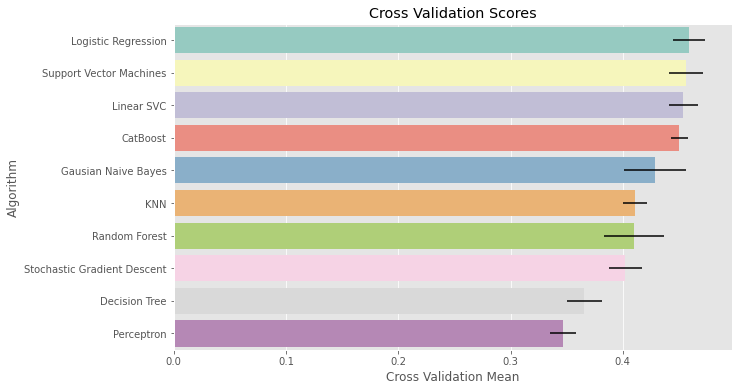

In [62]:
sns.barplot('Cross Validation Mean', 'Algorithm', data = cv_res, order = cv_res.sort_values(by = 'Cross Validation Mean', ascending = False)['Algorithm'], palette = 'Set3', **{'xerr': cv_std})
plt.ylabel('Algorithm')
plt.title('Cross Validation Scores');

Come sospettavamo, Decision Tree e Random Forest soffrivano di Overftting sul training set, il modello più performante dopo la cross validation è Logistic Regression con un'accuratezza del 46%. È possibile migliorare questo punteggio aggiustando i parametri di questo classificatore con grid search.

## Validazione degli Iperparametri per Logistic Regression

In [63]:
param_grid = {"C":np.logspace(-3,3,7), 
              "penalty":["l1","l2"]}
grid_log = GridSearchCV(LogisticRegression(), param_grid, cv=10)
grid_log.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']})

In [65]:
print("Best parameters: ", grid_log.best_params_) 

Best parameters:  {'C': 0.01, 'penalty': 'l2'}


In [82]:
#addestriamo il modello con questi parametri
predictions = grid_log.predict(X_test)
acc_logistic = round(grid_log.score(X_train, y_train) * 100, 2)

In [83]:
acc_logistic

46.74

L'accuratezza di Logistic Regressor con iperparametri validati è circa del **47%**. Possiamo visualizzare anche altre metriche di valutazione per capire meglio come funziona il nostro modello:

In [71]:
print(classification_report(y_test, Y_pred, target_names=['A','B','C','D']))

              precision    recall  f1-score   support

           A       0.42      0.53      0.47       821
           B       0.31      0.13      0.18       686
           C       0.47      0.59      0.52       714
           D       0.63      0.64      0.64       897

    accuracy                           0.48      3118
   macro avg       0.46      0.47      0.45      3118
weighted avg       0.47      0.48      0.46      3118



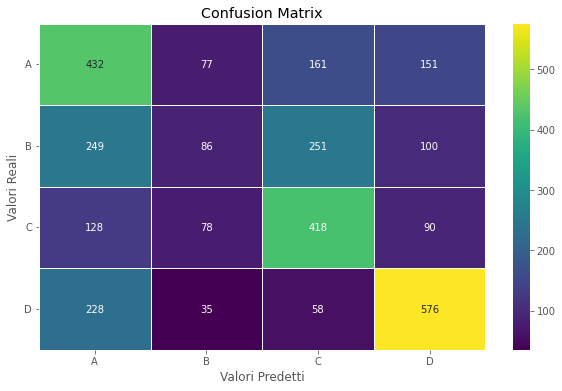

In [105]:
cm = confusion_matrix(y_test, predictions, labels=grid_log.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_log.classes_)

sns.heatmap(cm, annot=True, fmt='d',linewidths=.5, cmap='viridis', 
            xticklabels=['A','B','C','D'], yticklabels=['A','B','C','D'])

plt.xlabel('Valori Predetti')
plt.ylabel('Valori Reali')
plt.title('Confusion Matrix')
plt.yticks(rotation=0);

Dal classification report è possibile notare che la classe B ha sia una precision che una recall più basse rispetto alle altre classi, ciò è confermato anche dalla confusion matrix. È possibile notare come la classe B sia quella con più errori di classificazione, in particolare la classe B viene spesso classificata come A o come C. Questo problema può essere risolto aggiungendo più istanze appertenti alla classe B, in modo che l'algoritmo possa avere a disposizione maggiori elementi per distinguerle dalle altre.